# Importing Requred Packages and Modules

In [191]:
# imports
import geopandas as gpd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from libpysal.weights import KNN
from esda.moran import Moran
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from libpysal.weights import Queen
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#!pip install networkx
#!pip install xlrd

# Importing Data

In [192]:
svi_file = "Data Files/SVI_2018_US_county.csv"
svi_data = pd.read_csv(svi_file)

In [193]:
# Load the shapefile
shapefile_path = "Data Files/ADRD_shp_data/ADRD_output.shp"
counties_data = gpd.read_file(shapefile_path)

counties_data = counties_data.to_crs(epsg=5070)

In [194]:
NCHS_codes = pd.read_excel('Data files/NCHSURCodes2013.xlsx')
UIC_codes = pd.read_excel('Data files/UrbanInfluenceCodes2013.xls', engine='xlrd')
RUCC_codes = pd.read_excel('Data files/ruralurbancodes2013.xls', engine='xlrd')

In [195]:
counties_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery_St', 'Grocery__1',
       'Convienenc', 'Conviene_1', 'Residental', 'Population', 'Employment',
       'Jobs_per_H', 'Employme_1', '4_Leg_Pede', 'Job_Equili', 'Road_Netwo',
       'Auto_orien', 'Pedestrian', '3_Leg_Pede', 'Auto_Ori_1', 'Walkabilit',
       'Proportion', 'Jobs_with_', 'Working_ag', 'Transit_Fr', 'Distance_f',
       'Hospitals', 'of_people_', 'geometry'],
      dtype='object')

# Checking Data Structure and Cleaning

In [196]:
counties_data.shape

(3234, 53)

In [197]:
#counties_data.isnull().sum()

In [198]:
# Drop rows where 'state' is null because these are islands and territories
counties_data = counties_data.dropna(subset=['state'])

In [199]:
counties_data['state'].nunique()

50

In [200]:
counties_data.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP  ... Auto_Ori_1 Walkabilit Proportion  Jobs_with_  Working_ag  \
0  G4020  None  ...   0.480134   7.000000        0.0      1890.0      2122.5   
1  G4020  None  ...   0.470144   3.333333        0.0       285.0       721.0   
2  G4020  None  ...   0.712866   6.916667        0.0       250.0       438.0   
3  G4020   339  ...   0.000000  14.333333        0.0     41910.0     35341.0   
4  G4020  None  ...   0.166613   6.000000        0.0       482.0       785.0   

     Transit_Fr Distance_f  Hospitals  of_people_  \
0 -99999.000000  -99999.00          1         2.0   
1 -99999.000000  -99999.00          0         1.5   
2 -99999.000000  -99999.00          0         0.5   
3      1.626268     340.64         11        47.5   
4 -99999.000000  -99999.00          1         1.1   

                                            geometry  
0  POLYGON ((-83865.229 2111820.542, -83864.472 2...  
1  POLYGON ((-2091374.748 2887297.487, -2091836.9...  
2  POLYGON ((-784537.566 1250092.053, -784567.663...  
3  POLYGON ((-76226.295 1975273.48, -76220.615 19...  
4  POLYGON ((-192145.704 1899292.846, -192145.672...  

[5 rows x 53 columns]

# Merging ADRD shapefile with SVI data and Classification Codes

In [201]:
# Select the FIPS column
selected_columns = ["FIPS"]

# Find all columns that start with "EP_"
ep_columns = [col for col in svi_data.columns if col.startswith("EP_")]

# Combine them
final_columns = selected_columns + ep_columns

# Subset the dataframe
svi_data = svi_data[final_columns]

svi_data.head()


FIPS  EP_POV  EP_UNEMP   EP_PCI  EP_NOHSDP  EP_AGE65  EP_AGE17  EP_DISABL  \
0  35039  -999.0    -999.0   -999.0       13.8      18.0      23.7       16.1   
1   1001    15.4       4.2  29372.0       11.3      14.6      24.2       19.3   
2   1009    14.4       4.1  22656.0       19.8      17.8      23.4       14.2   
3   1013    23.5       6.7  20430.0       15.4      19.0      22.8       17.7   
4   1015    18.6       8.8  24706.0       15.9      16.8      21.9       20.8   

   EP_SNGPNT  EP_MINRTY  EP_LIMENG  EP_MUNIT  EP_MOBILE  EP_CROWD  EP_NOVEH  \
0       10.7       87.5        2.1       0.3       38.8       2.1       6.2   
1        7.5       25.0        0.8       3.8       18.4       1.4       5.6   
2        7.0       12.9        1.7       0.9       25.2       1.6       4.2   
3       10.5       48.1        0.5       1.3       26.2       1.8       7.8   
4       10.4       27.5        1.0       3.7       14.7       1.7       5.8   

   EP_GROUPQ  EP_UNINSUR  
0        1.7        10.6  
1        1.0         7.1  
2        0.9        11.0  
3        1.6        10.2  
4        2.7         9.4

In [202]:
merged_data = counties_data.merge(svi_data, on="FIPS", how="left")

merged_data.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP  ... EP_DISABL EP_SNGPNT EP_MINRTY  EP_LIMENG  EP_MUNIT  \
0  G4020  None  ...      10.6       6.8      11.6        1.3       3.6   
1  G4020  None  ...      23.6       3.2      12.8        0.5       1.5   
2  G4020  None  ...      22.9       5.8      48.0        0.9       0.0   
3  G4020   339  ...      10.7       7.9      18.4        2.1      18.3   
4  G4020  None  ...      17.0       5.5       4.7        1.0       3.0   

  EP_MOBILE EP_CROWD  EP_NOVEH  EP_GROUPQ EP_UNINSUR  
0       0.8      0.7       5.3        1.6        7.6  
1      14.6      1.6       1.2        1.3        7.2  
2      15.6      1.0       9.1        1.5        7.9  
3       1.7      2.1       5.7        4.3        7.3  
4       2.4      1.0       6.0        1.7        6.9  

[5 rows x 69 columns]

In [203]:
merged_data = merged_data.merge(RUCC_codes[['FIPS', 'RUCC_2013']], on='FIPS', how='left')
merged_data = merged_data.merge(UIC_codes[['FIPS', 'UIC_2013']], on='FIPS', how='left')

merged_data = merged_data.merge(
    NCHS_codes[['FIPS code', '2013 code']],  # Select relevant columns
    left_on='FIPS',  # Column name in merged_data
    right_on='FIPS code',  # Column name in NCHS_codes
    how='left'
).drop(columns=['FIPS code'])

In [204]:
merged_data.shape

(3138, 72)

In [205]:
merged_data['region'].value_counts()

region
South        1420
Midwest      1055
West          446
Northeast     217
Name: count, dtype: int64

In [206]:
merged_data['state'].nunique()

50

In [207]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery_St', 'Grocery__1',
       'Convienenc', 'Conviene_1', 'Residental', 'Population', 'Employment',
       'Jobs_per_H', 'Employme_1', '4_Leg_Pede', 'Job_Equili', 'Road_Netwo',
       'Auto_orien', 'Pedestrian', '3_Leg_Pede', 'Auto_Ori_1', 'Walkabilit',
       'Proportion', 'Jobs_with_', 'Working_ag', 'Transit_Fr', 'Distance_f',
       'Hospitals', 'of_people_', 'geometry', 'EP_POV', 'EP_UNEMP', 'EP_PCI',
       'EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'EP_UNINSUR', 'RUCC_2013', 'UIC_2013',
       '2013 code'],
      dty

# Creating Rural Categories

In [208]:
# Suppress all warnings
warnings.filterwarnings('ignore')

# Creating categories according to each classification system
merged_data['UI_category'] = merged_data['UIC_2013'].apply(lambda x: 
                                             "Non-Rural" if x == 1 else
                                             "Non-Rural" if x == 2 else
                                             "Rural" if 3 <= x <= 5 else
                                             "Rural" if 6 <= x <= 12 else 
                                             None)
merged_data['NCHS_category'] = merged_data['2013 code'].apply(lambda x: 
                                             "Non-Rural" if x == 1 else
                                             "Non-Rural" if x == 2 else
                                             "Non-Rural" if x == 3 else 
                                             "Non-Rural" if x == 4 else
                                             "Rural" if x == 5 else
                                             "Rural" if x == 6 else
                                             None)
merged_data['RUCC_category'] = merged_data['RUCC_2013'].apply(lambda x: 
                                             "Non-Rural" if x == 1 else
                                             "Non-Rural" if x == 2 else
                                             "Non-Rural" if x == 3 else
                                             "Rural" if 4 <= x <= 7 else
                                             "Rural" if 8 <= x <= 9 else 
                                             None)

In [209]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery_St', 'Grocery__1',
       'Convienenc', 'Conviene_1', 'Residental', 'Population', 'Employment',
       'Jobs_per_H', 'Employme_1', '4_Leg_Pede', 'Job_Equili', 'Road_Netwo',
       'Auto_orien', 'Pedestrian', '3_Leg_Pede', 'Auto_Ori_1', 'Walkabilit',
       'Proportion', 'Jobs_with_', 'Working_ag', 'Transit_Fr', 'Distance_f',
       'Hospitals', 'of_people_', 'geometry', 'EP_POV', 'EP_UNEMP', 'EP_PCI',
       'EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'EP_UNINSUR', 'RUCC_2013', 'UIC_2013',
       '2013 code', 'UI_catego

In [210]:
import geopandas as gpd

# Create GeoDataFrame using the existing 'geometry' column
ADRD_shapefile = gpd.GeoDataFrame(merged_data, geometry='geometry')

# (No need to touch the CRS if it's already correct)

# Export to shapefile
ADRD_shapefile.to_file('ADRD_shapefile.shp')

In [213]:
# Count rows where 'Transit_Fr' equals -999
num_placeholder_rows = (merged_data['Transit_Fr'] == -99999).sum()

print(f"Number of rows with -99999 in 'Transit_Fr': {num_placeholder_rows}")

Number of rows with -99999 in 'poverty (%)': 2778


In [214]:
num_placeholder_rows = (merged_data['EP_UNEMP'] == -999).sum()

print(f"Number of rows with -999 in 'EP_UNEMP': {num_placeholder_rows}")

Number of rows with -999 in 'poverty (%)': 1


In [216]:
num_placeholder_rows = (merged_data['EP_POV'] == -999).sum()

print(f"Number of rows with -999 in 'EP_POV': {num_placeholder_rows}")

Number of rows with -999 in 'EP_POV': 1


In [217]:
num_placeholder_rows = (merged_data['EP_PCI'] == -999).sum()

print(f"Number of rows with -999 in 'EP_PCI': {num_placeholder_rows}")

Number of rows with -999 in 'EP_PCI': 1


In [218]:
# Will exclude transit frequency and fill in the rest of the placeholders with 0

In [219]:
merged_data['EP_UNEMP'] = merged_data['EP_UNEMP'].replace(-999, 0)
merged_data['EP_PCI'] = merged_data['EP_PCI'].replace(-999, 0)
merged_data['EP_POV'] = merged_data['EP_POV'].replace(-999, 0)

# Checking Feature Correlation with SVI

In [220]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery_St', 'Grocery__1',
       'Convienenc', 'Conviene_1', 'Residental', 'Population', 'Employment',
       'Jobs_per_H', 'Employme_1', '4_Leg_Pede', 'Job_Equili', 'Road_Netwo',
       'Auto_orien', 'Pedestrian', '3_Leg_Pede', 'Auto_Ori_1', 'Walkabilit',
       'Proportion', 'Jobs_with_', 'Working_ag', 'Transit_Fr', 'Distance_f',
       'Hospitals', 'of_people_', 'geometry', 'EP_POV', 'EP_UNEMP', 'EP_PCI',
       'EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'EP_UNINSUR', 'RUCC_2013', 'UIC_2013',
       '2013 code', 'UI_catego

In [221]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery_St', 'Grocery__1',
       'Convienenc', 'Conviene_1', 'Residental', 'Population', 'Employment',
       'Jobs_per_H', 'Employme_1', '4_Leg_Pede', 'Job_Equili', 'Road_Netwo',
       'Auto_orien', 'Pedestrian', '3_Leg_Pede', 'Auto_Ori_1', 'Walkabilit',
       'Proportion', 'Jobs_with_', 'Working_ag', 'Transit_Fr', 'Distance_f',
       'Hospitals', 'of_people_', 'geometry', 'EP_POV', 'EP_UNEMP', 'EP_PCI',
       'EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT',
       'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD',
       'EP_NOVEH', 'EP_GROUPQ', 'EP_UNINSUR', 'RUCC_2013', 'UIC_2013',
       '2013 code', 'UI_catego

In [222]:
merged_data = merged_data.rename(columns={
    "Residental": "Residential density",
    "Population": "Population density",
    "Employment": "Employment density",
    "Jobs_per_H": "Jobs per household",
    "Employme_1": "Employment entropy",
    "Job_Equili": "Job Equilibrium Index",
    "Road_Netwo": "Road network density",
    "Auto_orien": "Auto oriented links",
    "Pedestrian": "Pedestrian oriented links",
    "4_Leg_Pede": "Pedestrian-oriented intersections (3 legs)",
    "3_Leg_Pede": "Pedestrian-oriented intersections (4 legs)",
    "Auto_Ori_1": "Auto oriented intersections",
    "Walkabilit": "Walkability Index",
    "Proportion": "Proportion of employment within transit",
    "Jobs_with_": "Jobs within 45 minutes",
    "Working_ag": "Working age population within 45 minutes",
    "Transit_Fr": "Transit frequency",
    "Distance_f": "Distance from transit",
    "Hospitals": "Hospitals",
    "Grocery_St": "Grocery store count",
    "Convienenc": "Convenience store count",
    "EP_POV": "Poverty (%)",
    "EP_UNEMP": "Unemployed (%)",
    "EP_PCI": "Per capita income",
    "EP_DISABL": "Population with disability (%)",
    "EP_SNGPNT": "Single-parent household (%)",
    "EP_MUNIT": "Multi-unit housing (%)",
    "EP_MOBILE": "Mobile homes (%)",
    "EP_CROWD": "Crowded housing (%)",
    "EP_NOVEH": "No-vehicle (%)",
    "EP_GROUPQ": "Group Quarter Living (%)",
    "EP_UNINSUR": "Uninsured (%)",
    "RUCC_category": "RUCC"
})

In [223]:
columns_to_drop = ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery__1',
       'Convenience store count', 'Conviene_1', 'Residential density', 'Population density', 'Employment density',
       'Jobs per household', 'Pedestrian-oriented intersections (four legs)', 'Job Equilibrium Index', 'Road network density',
    'Pedestrian oriented links per square mile', 'Pedestrian-oriented intersections (three legs)', 'Auto oriented links per square mile',
       'Proportion', 'Jobs within 45 minutes', 'Working age population within 45 minutes',
       'Hospitals','of_people_', 'geometry',
        'RUCC_2013', 'UIC_2013',
       '2013 code', 'UI_category', 'NCHS_category', 'RUCC_category']

In [224]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery store count',
       'Grocery__1', 'Convenience store count', 'Conviene_1',
       'Residential density', 'Population density', 'Employment density',
       'Jobs per household', 'Employment entropy',
       'Pedestrian-oriented intersections (3 legs)', 'Job Equilibrium Index',
       'Road network density', 'Auto oriented links',
       'Pedestrian oriented links',
       'Pedestrian-oriented intersections (4 legs)',
       'Auto oriented intersections', 'Walkability Index',
       'Proportion of employment within transit', 'Jobs within 45 minutes',
       'Working age population within 45 minutes', 'Transit frequency',
       'Distance 

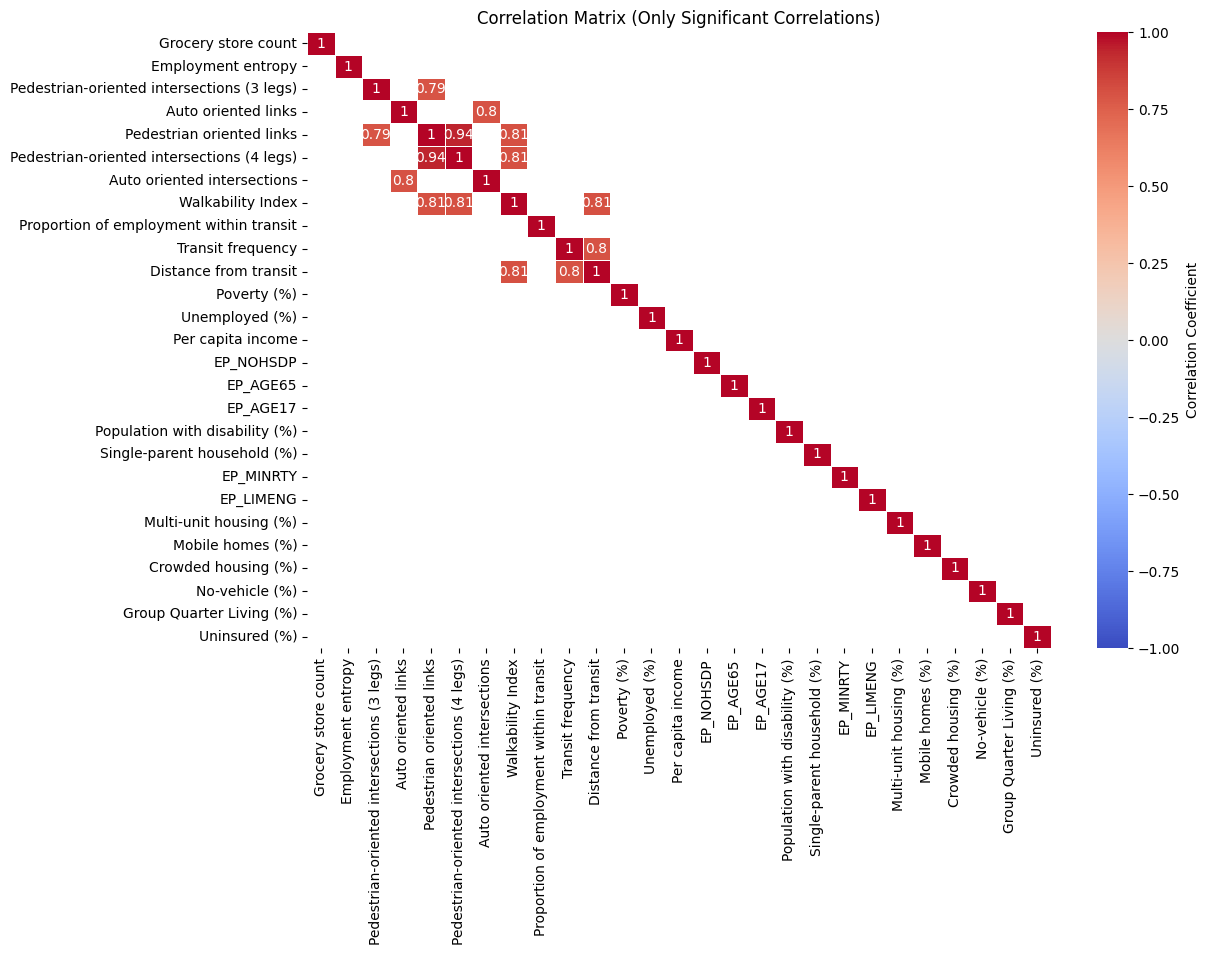

In [225]:
# Drop unnecessary columns
df_numeric = merged_data.drop(columns=columns_to_drop, errors='ignore')

# Keep only numeric columns
df_numeric = df_numeric.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Define significance threshold (absolute correlation below this will be grayed out)
threshold = 0.75  

# Create a mask: Values below threshold will be grayed out
mask = np.abs(correlation_matrix) < threshold  

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, linewidths=0.5, vmin=-1, vmax=1, 
            mask=mask, cbar_kws={'label': 'Correlation Coefficient'})

plt.title("Correlation Matrix (Only Significant Correlations)")
plt.show()

# XGBoost Model Functions

In [226]:
def train_xgboost_model(df, feature_list, target='Prevalence', test_size=0.3, val_size=0.5, random_state=42):
    """
    Trains an XGBoost model on the given dataframe with specified features.
    This also returns the test set used during training.
    """

    # Select features and target
    X = df[feature_list]
    y = df[target]

    # Split dataset
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=val_size, random_state=random_state)

    # Convert to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Define hyperparameter grid
    param_grid = {
        'max_depth': [4, 6, 8],
        'eta': [0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Find best hyperparameters using cross-validation
    best_params = None
    best_rmse = float("inf")

    for max_depth in param_grid['max_depth']:
        for eta in param_grid['eta']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:

                    params = {
                        'objective': 'reg:squarederror',
                        'eval_metric': 'rmse',
                        'max_depth': max_depth,
                        'eta': eta,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree
                    }

                    # Perform cross-validation
                    cv_results = xgb.cv(
                        params,
                        dtrain,
                        num_boost_round=500,
                        nfold=5,
                        early_stopping_rounds=10,
                        metrics='rmse',
                        as_pandas=True,
                        seed=random_state
                    )

                    mean_rmse = cv_results['test-rmse-mean'].min()

                    if mean_rmse < best_rmse:
                        best_rmse = mean_rmse
                        best_params = params

    print("Best Hyperparameters:", best_params)

    # Train final model with best hyperparameters
    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=100,
        evals=[(dval, "Validation")],
        early_stopping_rounds=10
    )

    # Predict on validation set
    y_val_pred = final_model.predict(dval)

    # Compute RMSE and R²
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")

    # Return the trained model and the test data
    return {
        'model': final_model,
        'best_params': best_params,
        'rmse': rmse,
        'r2': r2,
        'X_test': X_test, 
        'y_test': y_test
    }


In [227]:
def test_xgboost_model(model, X_test, y_test):
    """
    Tests the trained XGBoost model on the test set and calculates performance metrics, including AIC.

    Parameters:
    model (xgb.Booster): The trained XGBoost model.
    X_test (pd.DataFrame): Test feature data.
    y_test (pd.Series): True target values for the test set.

    Returns:
    dict: Contains RMSE, R², MAE, and AIC metrics for the test set.
    """
    # Convert test set to DMatrix format
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Predict on the test set
    y_test_pred = model.predict(dtest)

    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))  
    r2 = r2_score(y_test, y_test_pred)  
    mae = mean_absolute_error(y_test, y_test_pred) 

    # Calculate AIC
    n = len(y_test)  # Number of observations
    k = X_test.shape[1]  # Number of predictors
    rss = np.sum((y_test - y_test_pred) ** 2)  # Residual Sum of Squares (RSS)
    aic = n * np.log(rss / n) + 2 * k

    # Print results
    print(f"Test Set Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"AIC: {aic:.4f}")

    return {
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'aic': aic,
        'y_pred': y_test_pred
    }


In [228]:
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_shap_values(model, X_test):
    """
    Generates and displays SHAP beeswarm and feature importance plots for the given model.
    
    Parameters:
    model: The trained model (xgboost.XGBModel or xgb.Booster).
    X_test (pd.DataFrame): The feature test set.
    
    Returns:
    shap_feature_importance (pd.DataFrame): DataFrame of mean absolute SHAP values per feature.
    """
    # Create SHAP explainer
    explainer = shap.Explainer(model)

    # Compute SHAP values
    shap_values = explainer(X_test)

    # --- SHAP Beeswarm Plot ---
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test)

    # --- SHAP Feature Importance (Mean |SHAP| per feature) ---
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'mean_abs_shap_value': mean_abs_shap
    }).sort_values(by='mean_abs_shap_value', ascending=False)

    # Plot SHAP feature importances
    plt.figure(figsize=(10, 6))
    shap_feature_importance.set_index('feature').plot(kind='bar', legend=False)
    plt.title('SHAP Feature Importance (Mean |SHAP Value|)')
    plt.ylabel('Mean |SHAP Value|')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Model-native feature importances ---
    plt.figure(figsize=(10, 6))
    if isinstance(model, xgb.Booster):
        importance_dict = model.get_score(importance_type='weight')
        feature_importances = pd.Series(importance_dict).sort_values(ascending=False)
    else:
        feature_importances = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

    feature_importances.plot(kind='bar', color='skyblue')
    for i, value in enumerate(feature_importances):
        plt.text(i, value, f"{value:.4f}", ha='center', va='bottom')

    plt.title('Model-native Feature Importances (XGBoost)')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return shap_feature_importance


# VIF Function

In [229]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df):
    """Calculate VIF for each feature in the dataset."""
    X = df.copy()  
    X = X.assign(constant=1)  # Add a constant for stability
    vif_data = pd.DataFrame({
        "Feature": X.columns[:-1],  # Exclude the constant
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1] - 1)]
    })
    return vif_data

# Random Forest Model Functions

In [230]:
def train_random_forest_model(df, features, target_col='Prevalence'):
    """
    Trains a Random Forest model with hyperparameter tuning, and evaluates on a validation set.
    
    Parameters:
    df: The input dataframe containing the features and target variable.
    features: List of feature column names to use for training.
    target_col: Name of the target variable column (default is 'Prevalence').
    
    Returns:
    dict: Dictionary containing the trained model and evaluation metrics.
    """
    # Define features and target
    X = df[features]
    y = df[target_col]

    # Step 1: Train-Validation Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)  
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)  

    # Step 2: Define Hyperparameter Grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Step 3: Hyperparameter Tuning using Grid Search
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Step 4: Train Final Model with Best Parameters
    final_rf = RandomForestRegressor(**best_params, random_state=42)
    final_rf.fit(X_train, y_train)

    # Step 5: Predict on Validation Set
    y_val_pred = final_rf.predict(X_val)

    # Step 6: Compute RMSE and R² for Validation Set
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)

    # Print validation results
    print(f"Validation RMSE (Random Forest): {rmse:.4f}")
    print(f"Validation R² (Random Forest): {r2:.4f}")

    # Return results as a dictionary
    return {
        'model': final_rf,
        'X_test': X_test,
        'y_test': y_test,
        'rmse': rmse,
        'r2': r2
    }

In [231]:
def test_random_forest_model(model, X_test, y_test):
    """
    Test the performance of the Random Forest model on the test set, including AIC calculation.
    
    Parameters:
    model (RandomForestRegressor): The trained Random Forest model.
    X_test (pd.DataFrame): The test feature set.
    y_test (pd.Series): The test target values.
    
    Returns:
    dict: Contains RMSE, R², MAE, and AIC metrics for the test set.
    """
    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))  
    r2 = r2_score(y_test, y_test_pred)  
    mae = mean_absolute_error(y_test, y_test_pred) 

    # Calculate AIC
    n = len(y_test)  # Number of observations
    rss = np.sum((y_test - y_test_pred) ** 2)  # Residual Sum of Squares (RSS)
    k = model.n_estimators + X_test.shape[1]  # Number of parameters = number of trees + number of features
    aic = n * np.log(rss / n) + 2 * k

    # Print results
    print(f"Test Set Performance (Random Forest):")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"AIC: {aic:.4f}")

    return {
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'aic': aic,
        'y_pred': y_test_pred
    }


In [232]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def shap_feature_importance_rf(model, X_train, features):
    """
    Plots SHAP summary (beeswarm) and both SHAP-based and traditional feature importance for a trained Random Forest model.
    Also returns SHAP importance scores (mean absolute SHAP value per feature).
    
    Parameters:
    model (RandomForestRegressor): The trained Random Forest model.
    X_train (pd.DataFrame): The training features.
    features (list): List of feature column names.
    
    Returns:
    shap_feature_importance (pd.DataFrame): Feature and mean_abs_shap_value sorted by importance.
    """
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_train)
    
    # If classification with multiple outputs, use class 1 (or average across classes)
    if isinstance(shap_values, list):
        shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]

    # --- SHAP Beeswarm Plot ---
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=features)
    
    # --- SHAP Feature Importance Calculation ---
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_feature_importance = pd.DataFrame({
        'feature': features,
        'mean_abs_shap_value': mean_abs_shap
    }).sort_values(by='mean_abs_shap_value', ascending=False).reset_index(drop=True)

    # Optional: print or log top features
    print("\nTop SHAP Feature Importances:")
    print(shap_feature_importance)

    # --- Traditional Feature Importance Plot ---
    feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar', color='skyblue')
    for i, value in enumerate(feature_importances):
        plt.text(i, value, f"{value:.4f}", ha='center', va='bottom')
    plt.title('Model-native Feature Importances (Random Forest)')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ✅ Return DataFrame with scores
    return shap_feature_importance


In [233]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery store count',
       'Grocery__1', 'Convenience store count', 'Conviene_1',
       'Residential density', 'Population density', 'Employment density',
       'Jobs per household', 'Employment entropy',
       'Pedestrian-oriented intersections (3 legs)', 'Job Equilibrium Index',
       'Road network density', 'Auto oriented links',
       'Pedestrian oriented links',
       'Pedestrian-oriented intersections (4 legs)',
       'Auto oriented intersections', 'Walkability Index',
       'Proportion of employment within transit', 'Jobs within 45 minutes',
       'Working age population within 45 minutes', 'Transit frequency',
       'Distance 

## Feature Sets and VIF's

In [255]:
#Subsetting BE variables
built_environment_features = ["Grocery store count", "Employment entropy", "Auto oriented links", "Walkability Index"]

predictors = merged_data[built_environment_features]  # Select only predictor columns
print(compute_vif(predictors))

               Feature       VIF
0  Grocery store count  1.222937
1   Employment entropy  1.046664
2  Auto oriented links  1.057092
3    Walkability Index  1.323789


In [256]:
# Subsetting BE and SVI variables
built_env_svi = ["Grocery store count", "Employment entropy", "Auto oriented links", "Walkability Index", 
            'Unemployed (%)', 'Per capita income', "Poverty (%)",
            'Population with disability (%)', 'Single-parent household (%)', 'Multi-unit housing (%)', 'Mobile homes (%)', 
            'Crowded housing (%)', 'No-vehicle (%)', 'Group Quarter Living (%)', 'Uninsured (%)']

predictors = merged_data[built_env_svi]  # Select only predictor columns
print(compute_vif(predictors))

                           Feature       VIF
0              Grocery store count  1.557372
1               Employment entropy  1.127038
2              Auto oriented links  1.104091
3                Walkability Index  2.424313
4                   Unemployed (%)  2.035645
5                Per capita income  3.401899
6                      Poverty (%)  3.667277
7   Population with disability (%)  2.217592
8      Single-parent household (%)  1.832430
9           Multi-unit housing (%)  2.674527
10                Mobile homes (%)  2.101546
11             Crowded housing (%)  1.747102
12                  No-vehicle (%)  1.948468
13        Group Quarter Living (%)  1.126451
14                   Uninsured (%)  1.629201


# GLOBAL FUNCTIONS

# *Global* XGBoost BE Only

In [257]:
results = train_xgboost_model(merged_data, built_environment_features)

Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 4, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0}
[0]	Validation-rmse:1.42691
[1]	Validation-rmse:1.42116
[2]	Validation-rmse:1.41519
[3]	Validation-rmse:1.40974
[4]	Validation-rmse:1.40594
[5]	Validation-rmse:1.40276
[6]	Validation-rmse:1.39948
[7]	Validation-rmse:1.39612
[8]	Validation-rmse:1.39295
[9]	Validation-rmse:1.38948
[10]	Validation-rmse:1.38818
[11]	Validation-rmse:1.38615
[12]	Validation-rmse:1.38390
[13]	Validation-rmse:1.38172
[14]	Validation-rmse:1.37953
[15]	Validation-rmse:1.37712
[16]	Validation-rmse:1.37466
[17]	Validation-rmse:1.37354
[18]	Validation-rmse:1.37206
[19]	Validation-rmse:1.37001
[20]	Validation-rmse:1.36961
[21]	Validation-rmse:1.36744
[22]	Validation-rmse:1.36645
[23]	Validation-rmse:1.36548
[24]	Validation-rmse:1.36413
[25]	Validation-rmse:1.36282
[26]	Validation-rmse:1.36182
[27]	Validation-rmse:1.36054
[28]	Validation-rmse:1.35920
[29]	Validation-rm

## Test Set Performance

In [258]:
test_results = test_xgboost_model(results['model'], results['X_test'], results['y_test'])

Test Set Performance:
RMSE: 1.4257
R² Score: 0.0961
MAE: 1.0158
AIC: 342.0636


## SHAP Values

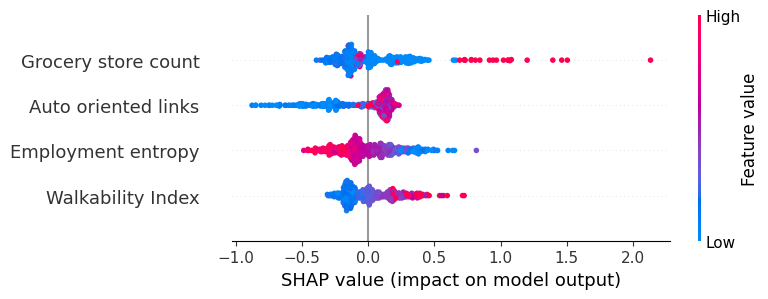

<Figure size 1000x600 with 0 Axes>

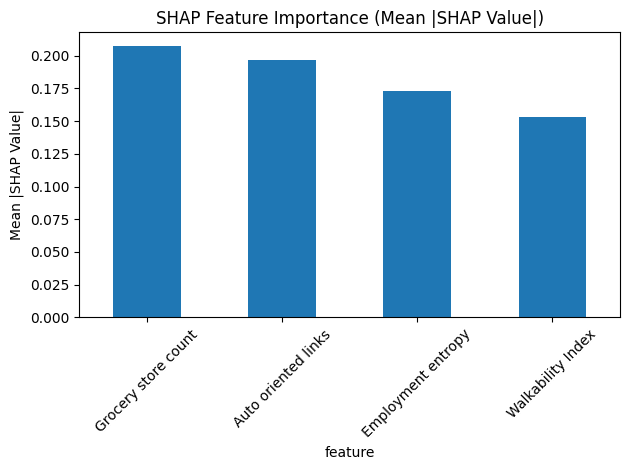

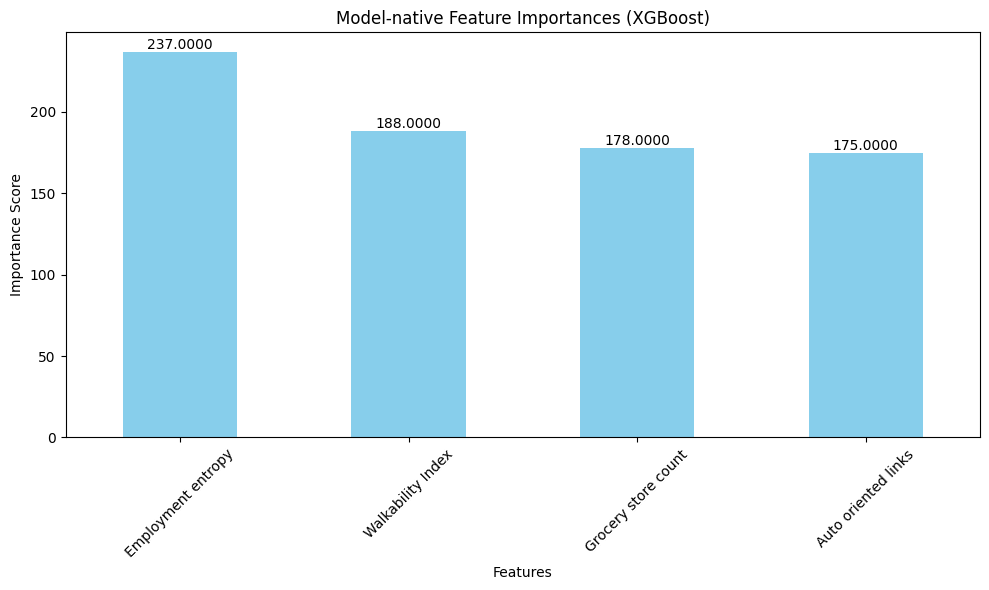

feature  mean_abs_shap_value
0  Grocery store count             0.207473
2  Auto oriented links             0.196463
1   Employment entropy             0.172721
3    Walkability Index             0.153292

In [259]:
plot_shap_values(results['model'], results['X_test'])

# Global XGBoost with SVI subset

In [260]:
results = train_xgboost_model(merged_data, built_env_svi)

Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 6, 'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}
[0]	Validation-rmse:1.39062
[1]	Validation-rmse:1.34722
[2]	Validation-rmse:1.32160
[3]	Validation-rmse:1.28887
[4]	Validation-rmse:1.26208
[5]	Validation-rmse:1.23908
[6]	Validation-rmse:1.22194
[7]	Validation-rmse:1.20417
[8]	Validation-rmse:1.18866
[9]	Validation-rmse:1.17056
[10]	Validation-rmse:1.15676
[11]	Validation-rmse:1.13658
[12]	Validation-rmse:1.12452
[13]	Validation-rmse:1.11462
[14]	Validation-rmse:1.11288
[15]	Validation-rmse:1.10681
[16]	Validation-rmse:1.10303
[17]	Validation-rmse:1.09123
[18]	Validation-rmse:1.08150
[19]	Validation-rmse:1.07557
[20]	Validation-rmse:1.06966
[21]	Validation-rmse:1.06683
[22]	Validation-rmse:1.06372
[23]	Validation-rmse:1.05837
[24]	Validation-rmse:1.05458
[25]	Validation-rmse:1.05353
[26]	Validation-rmse:1.05101
[27]	Validation-rmse:1.04968
[28]	Validation-rmse:1.04808
[29]	Validation-rms

In [261]:
test_results = test_xgboost_model(results['model'], results['X_test'], results['y_test'])

Test Set Performance:
RMSE: 1.0448
R² Score: 0.5145
MAE: 0.7710
AIC: 71.3015


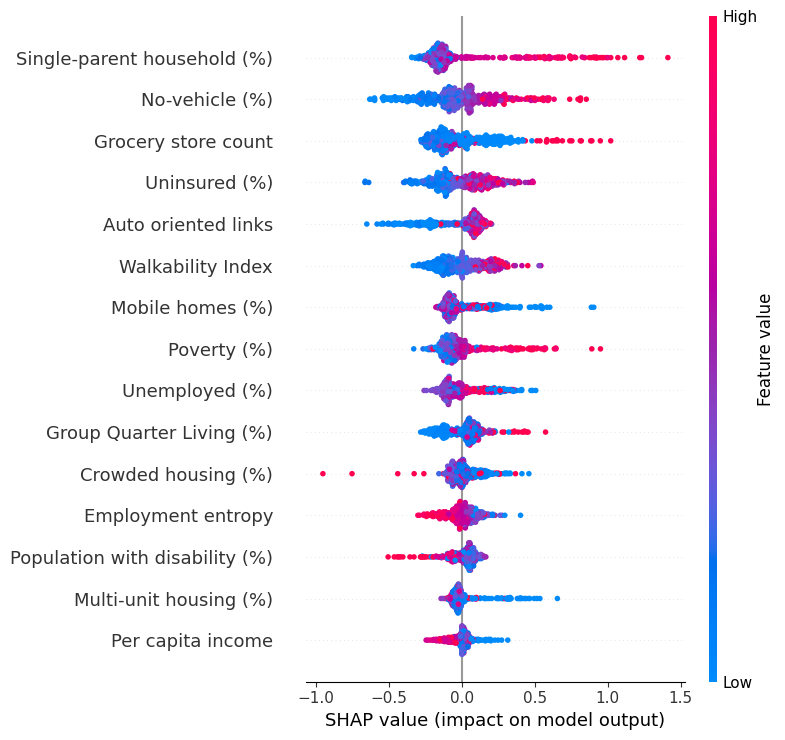

<Figure size 1000x600 with 0 Axes>

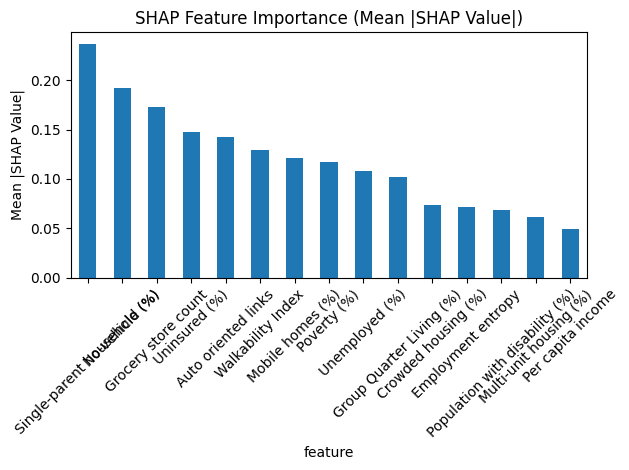

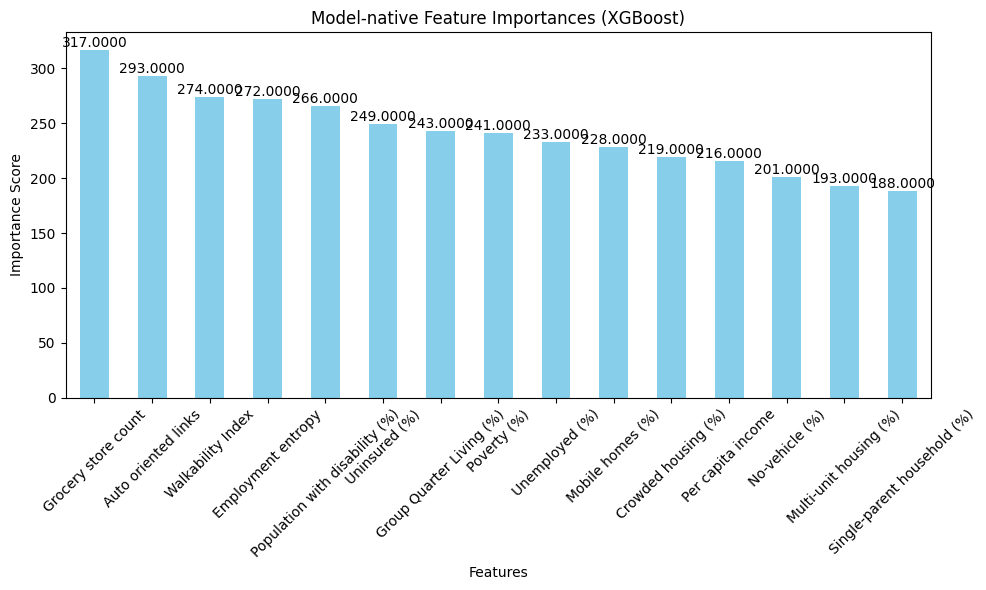

feature  mean_abs_shap_value
8      Single-parent household (%)             0.236850
12                  No-vehicle (%)             0.192188
0              Grocery store count             0.173403
14                   Uninsured (%)             0.147885
2              Auto oriented links             0.142653
3                Walkability Index             0.128930
10                Mobile homes (%)             0.121710
6                      Poverty (%)             0.116835
4                   Unemployed (%)             0.108097
13        Group Quarter Living (%)             0.101725
11             Crowded housing (%)             0.073289
1               Employment entropy             0.071345
7   Population with disability (%)             0.068880
9           Multi-unit housing (%)             0.061766
5                Per capita income             0.049624

In [262]:
plot_shap_values(results['model'], results['X_test'])

# RF Global BE Only

In [263]:
results = train_random_forest_model(merged_data, built_environment_features)

# The `train_random_forest_model` function returns a dictionary with the trained model, test data, and evaluation metrics
final_rf = results['model']
X_test = results['X_test']
y_test = results['y_test']
rmse = results['rmse']
r2 = results['r2']

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Validation RMSE (Random Forest): 1.3589
Validation R² (Random Forest): 0.1008


In [264]:
test_random_forest_model(final_rf, X_test, y_test)

Test Set Performance (Random Forest):
RMSE: 1.4292
R² Score: 0.0917
MAE: 1.0267
AIC: 744.3852


{'rmse': np.float64(1.429174209523376),
 'r2': 0.09167830207376848,
 'mae': 1.0266708285639714,
 'aic': np.float64(744.3851871172171),
 'y_pred': array([11.21808517, 10.33945736, 11.31663314, 11.50048033, 10.83662221,
        10.92208256, 11.580912  , 11.65637573, 11.34186099, 10.57918545,
        10.76391269, 11.13767918, 10.98801735, 11.21835381, 11.39459899,
        11.36786619, 10.38253343, 11.50034298, 11.19235135, 10.39553681,
        11.79738282, 10.98992695, 10.30000233, 10.64509035, 10.95755983,
        11.9012065 , 11.25306192,  9.42465324, 10.24534141, 11.76227497,
        11.18666389, 12.41364383, 11.06288827, 10.76548996, 11.27784171,
        10.3524571 , 11.28925091, 11.43012161,  9.70131237, 11.01627399,
        10.80310269, 10.92336007, 10.80614842, 10.69611175, 11.39885972,
        11.3960349 , 11.14741093, 11.05743558, 10.86821516, 11.4812665 ,
        11.21866251, 11.3919298 ,  9.81769354, 10.62291283, 11.70086845,
        11.21381992, 12.17505797, 11.82308704, 10.61

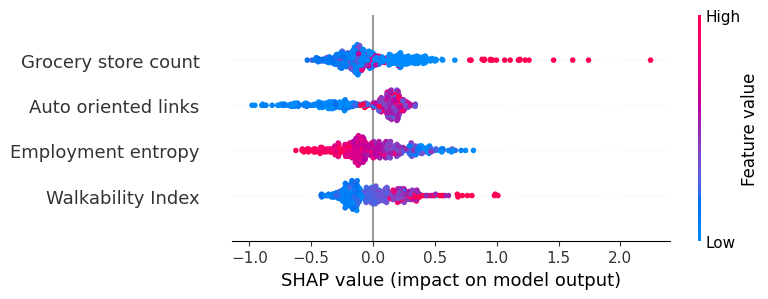


Top SHAP Feature Importances:
               feature  mean_abs_shap_value
0  Grocery store count             0.234762
1  Auto oriented links             0.230452
2   Employment entropy             0.204506
3    Walkability Index             0.189447


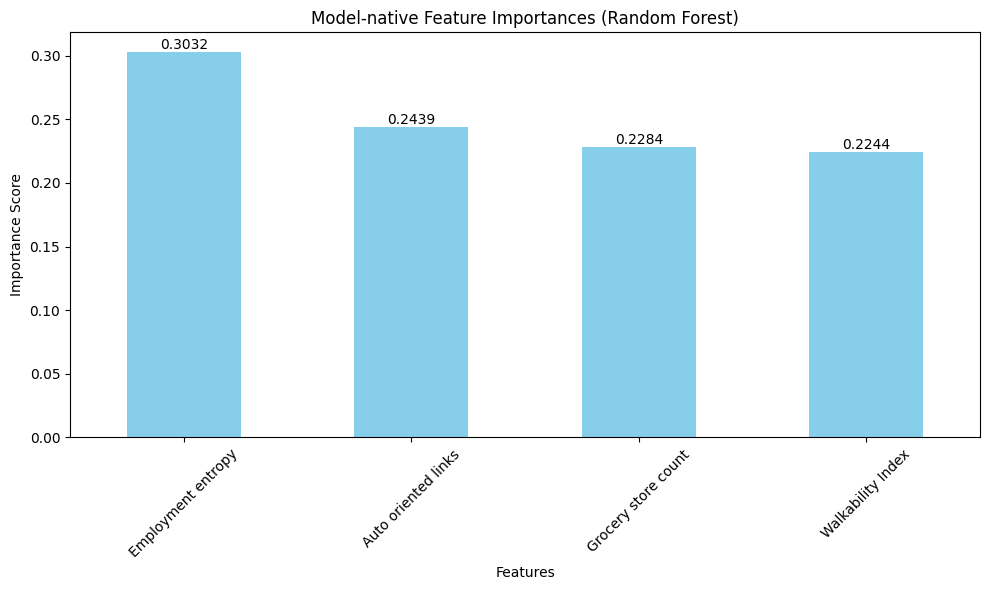

feature  mean_abs_shap_value
0  Grocery store count             0.234762
1  Auto oriented links             0.230452
2   Employment entropy             0.204506
3    Walkability Index             0.189447

In [265]:
X_train = results['X_test'].iloc[:len(X_test)]  # Adjust as needed based on your data splitting method

shap_feature_importance_rf(final_rf, X_train, built_environment_features)

# Global RF with SVI subset

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Validation RMSE (Random Forest): 1.0254
Validation R² (Random Forest): 0.4880
Test Set Performance (Random Forest):
RMSE: 1.0626
R² Score: 0.4979
MAE: 0.7725
AIC: 687.1583


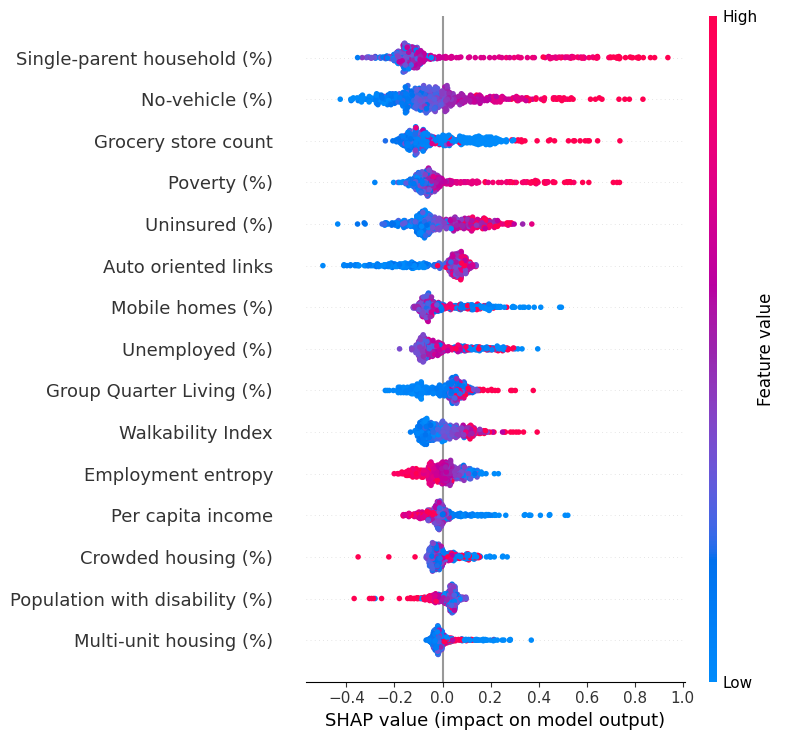


Top SHAP Feature Importances:
                           feature  mean_abs_shap_value
0      Single-parent household (%)             0.206739
1                   No-vehicle (%)             0.156614
2              Grocery store count             0.124350
3                      Poverty (%)             0.108063
4                    Uninsured (%)             0.105888
5              Auto oriented links             0.100652
6                 Mobile homes (%)             0.086323
7                   Unemployed (%)             0.085255
8         Group Quarter Living (%)             0.079328
9                Walkability Index             0.069539
10              Employment entropy             0.060691
11               Per capita income             0.056897
12             Crowded housing (%)             0.046520
13  Population with disability (%)             0.043660
14          Multi-unit housing (%)             0.036412


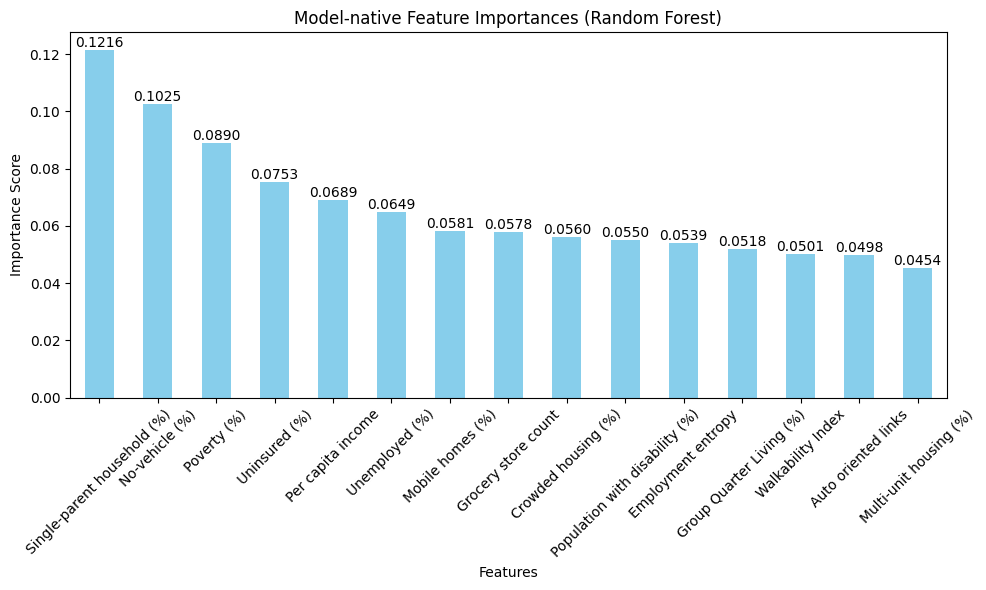

feature  mean_abs_shap_value
0      Single-parent household (%)             0.206739
1                   No-vehicle (%)             0.156614
2              Grocery store count             0.124350
3                      Poverty (%)             0.108063
4                    Uninsured (%)             0.105888
5              Auto oriented links             0.100652
6                 Mobile homes (%)             0.086323
7                   Unemployed (%)             0.085255
8         Group Quarter Living (%)             0.079328
9                Walkability Index             0.069539
10              Employment entropy             0.060691
11               Per capita income             0.056897
12             Crowded housing (%)             0.046520
13  Population with disability (%)             0.043660
14          Multi-unit housing (%)             0.036412

In [266]:
results = train_random_forest_model(merged_data, built_env_svi)

# The `train_random_forest_model` function returns a dictionary with the trained model, test data, and evaluation metrics
final_rf = results['model']
X_test = results['X_test']
y_test = results['y_test']
rmse = results['rmse']
r2 = results['r2']

test_random_forest_model(final_rf, X_test, y_test)

X_train = results['X_test'].iloc[:len(X_test)]  # Adjust as needed based on your data splitting method

shap_feature_importance_rf(final_rf, X_train, built_env_svi)

# Regional Analysis

## Visualizing Counties & Their Regions

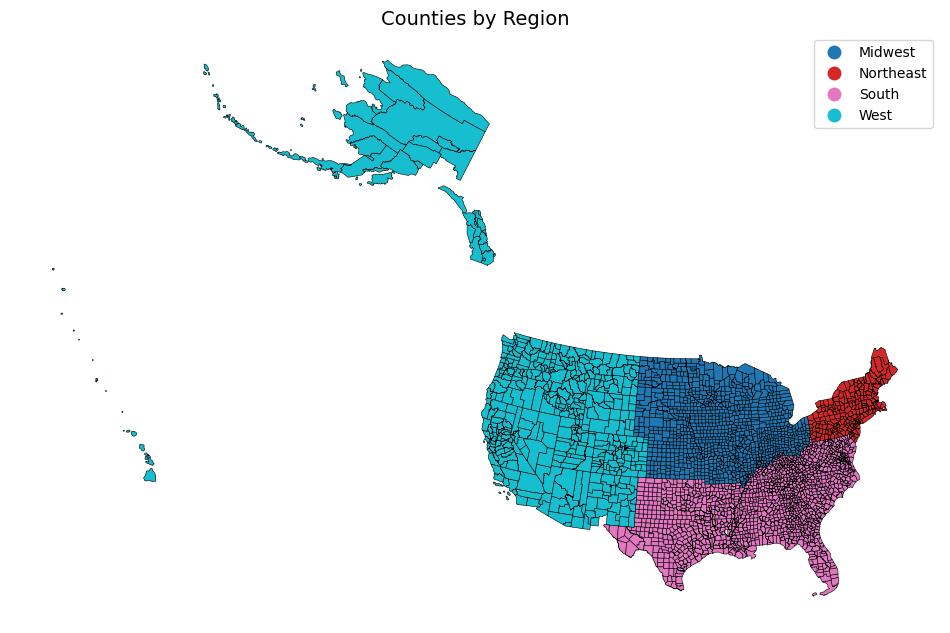

In [267]:
# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the counties, coloring them by region
counties_data.plot(column="region", cmap="tab10", legend=True, edgecolor="black", linewidth=0.4, ax=ax)

# Add a title
ax.set_title("Counties by Region", fontsize=14)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Show the plot
plt.show()

In [268]:
# Subsetting by region
northeast_df = merged_data[merged_data["region"] == "Northeast"]
midwest_df = merged_data[merged_data["region"] == "Midwest"]
south_df = merged_data[merged_data["region"] == "South"]
west_df = merged_data[merged_data["region"] == "West"]

regions = [northeast_df,midwest_df,south_df, west_df]

In [269]:
avg_uic_by_region = {name: df['RUCC_2013'].median() for name, df in zip(['Northeast', 'Midwest', 'South', 'West'], regions)}

print(avg_uic_by_region)

{'Northeast': np.float64(3.0), 'Midwest': np.float64(6.0), 'South': np.float64(6.0), 'West': np.float64(6.0)}


# Regional XGBoost Functions

## Regional XGBoost BE Only


Training XGBoost model for region: Northeast
Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 4, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.6}
[0]	Validation-rmse:1.28550
[1]	Validation-rmse:1.16387
[2]	Validation-rmse:1.08895
[3]	Validation-rmse:1.03852
[4]	Validation-rmse:0.96378
[5]	Validation-rmse:0.90003
[6]	Validation-rmse:0.84685
[7]	Validation-rmse:0.80654
[8]	Validation-rmse:0.77291
[9]	Validation-rmse:0.75948
[10]	Validation-rmse:0.74295
[11]	Validation-rmse:0.73587
[12]	Validation-rmse:0.73658
[13]	Validation-rmse:0.71708
[14]	Validation-rmse:0.71170
[15]	Validation-rmse:0.71077
[16]	Validation-rmse:0.70204
[17]	Validation-rmse:0.69307
[18]	Validation-rmse:0.69320
[19]	Validation-rmse:0.67959
[20]	Validation-rmse:0.67866
[21]	Validation-rmse:0.67842
[22]	Validation-rmse:0.67499
[23]	Validation-rmse:0.67200
[24]	Validation-rmse:0.67035
[25]	Validation-rmse:0.66781
[26]	Validation-rmse:0.66665
[27]	Validation-rmse:0.66387
[2

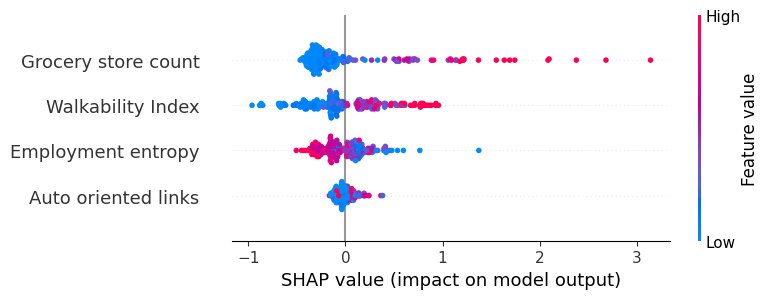

<Figure size 1000x600 with 0 Axes>

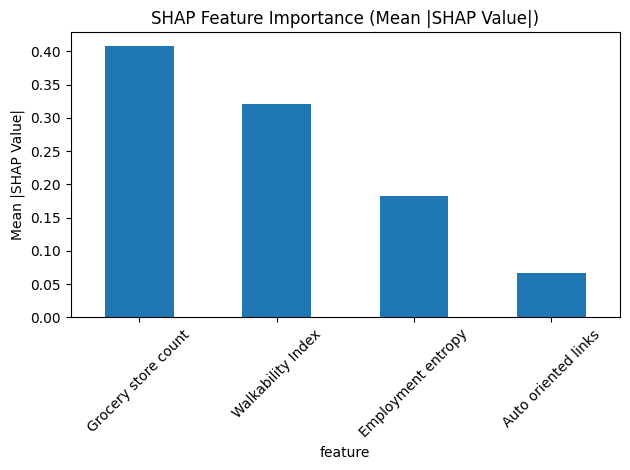

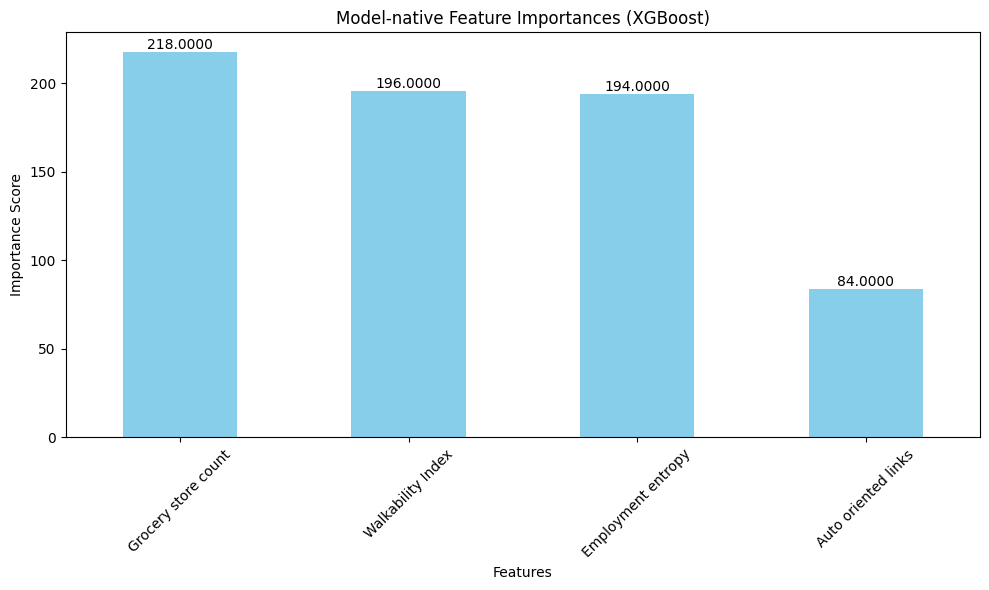


SHAP summary for Northeast:

               feature  mean_abs_shap_value
0  Grocery store count             0.408282
3    Walkability Index             0.320546
1   Employment entropy             0.182041
2  Auto oriented links             0.066499

Training XGBoost model for region: Midwest
Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 4, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0}
[0]	Validation-rmse:0.85078
[1]	Validation-rmse:0.84279
[2]	Validation-rmse:0.83523
[3]	Validation-rmse:0.82736
[4]	Validation-rmse:0.82103
[5]	Validation-rmse:0.81561
[6]	Validation-rmse:0.81230
[7]	Validation-rmse:0.80861
[8]	Validation-rmse:0.80219
[9]	Validation-rmse:0.79592
[10]	Validation-rmse:0.79227
[11]	Validation-rmse:0.78746
[12]	Validation-rmse:0.78410
[13]	Validation-rmse:0.78080
[14]	Validation-rmse:0.77791
[15]	Validation-rmse:0.77576
[16]	Validation-rmse:0.77325
[17]	Validation-rmse:0.77162
[18]	Validation-rmse:0.77178
[19]	Validatio

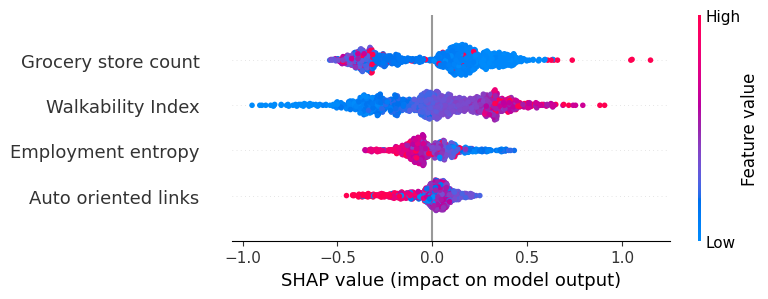

<Figure size 1000x600 with 0 Axes>

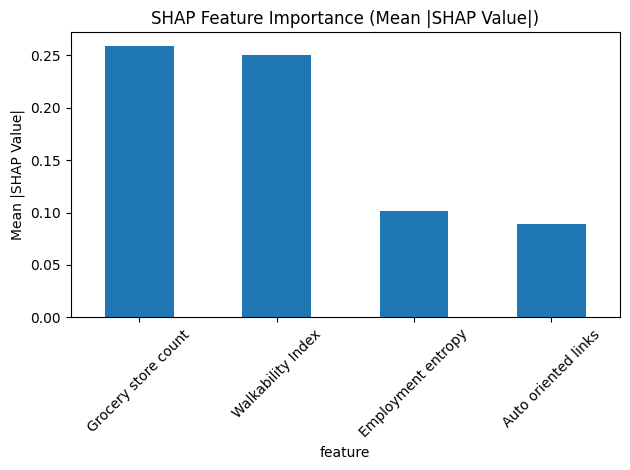

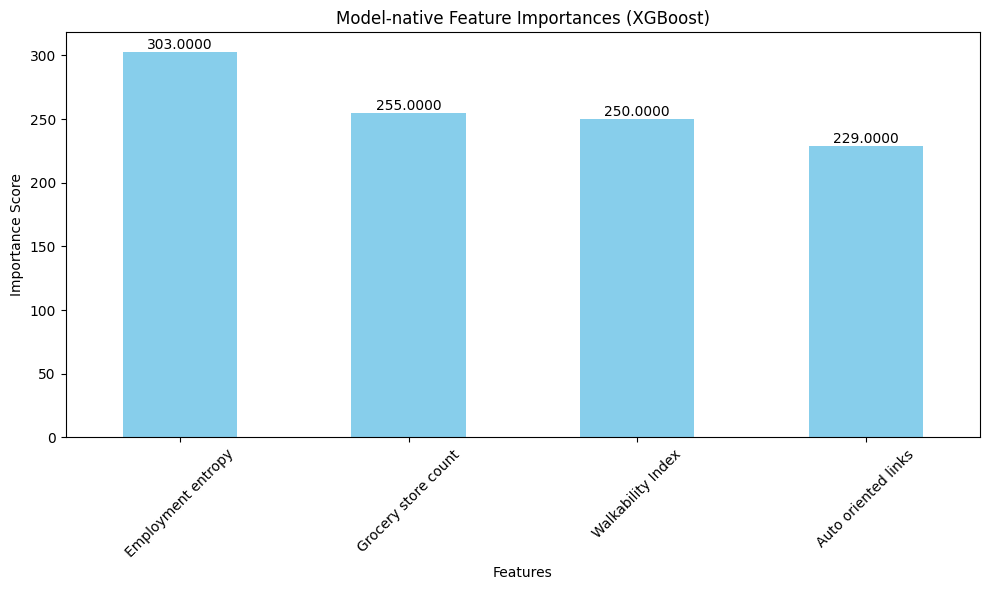


SHAP summary for Midwest:

               feature  mean_abs_shap_value
0  Grocery store count             0.258928
3    Walkability Index             0.250374
1   Employment entropy             0.101356
2  Auto oriented links             0.088650

Training XGBoost model for region: South
Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 4, 'eta': 0.2, 'subsample': 0.6, 'colsample_bytree': 1.0}
[0]	Validation-rmse:1.60008
[1]	Validation-rmse:1.58696
[2]	Validation-rmse:1.57235
[3]	Validation-rmse:1.57168
[4]	Validation-rmse:1.56772
[5]	Validation-rmse:1.56398
[6]	Validation-rmse:1.56656
[7]	Validation-rmse:1.56983
[8]	Validation-rmse:1.56767
[9]	Validation-rmse:1.57647
[10]	Validation-rmse:1.58045
[11]	Validation-rmse:1.58713
[12]	Validation-rmse:1.59000
[13]	Validation-rmse:1.59633
[14]	Validation-rmse:1.59446
[15]	Validation-rmse:1.59425
Validation RMSE: 1.5942
Validation R²: -0.0008
Test Set Performance:
RMSE: 1.4631
R² Score: 0.2191
MAE: 1.

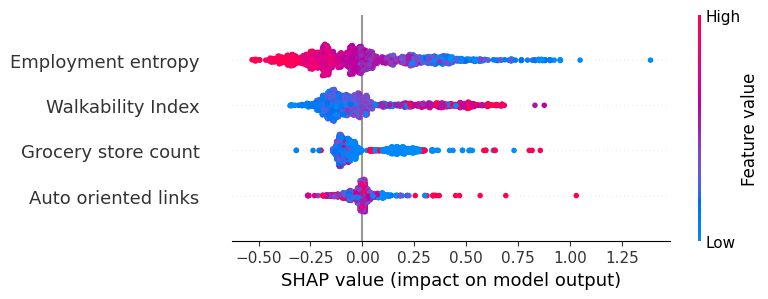

<Figure size 1000x600 with 0 Axes>

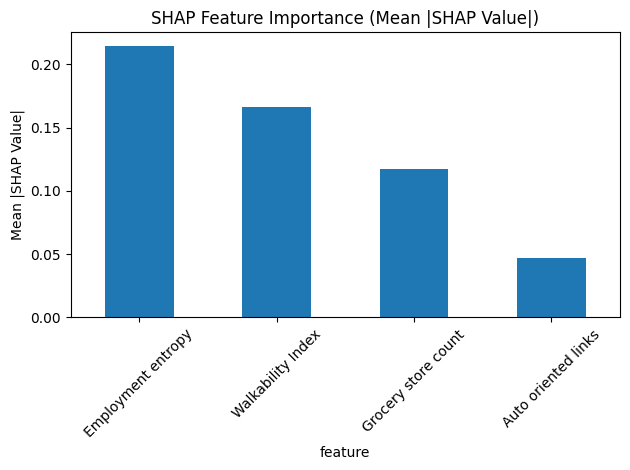

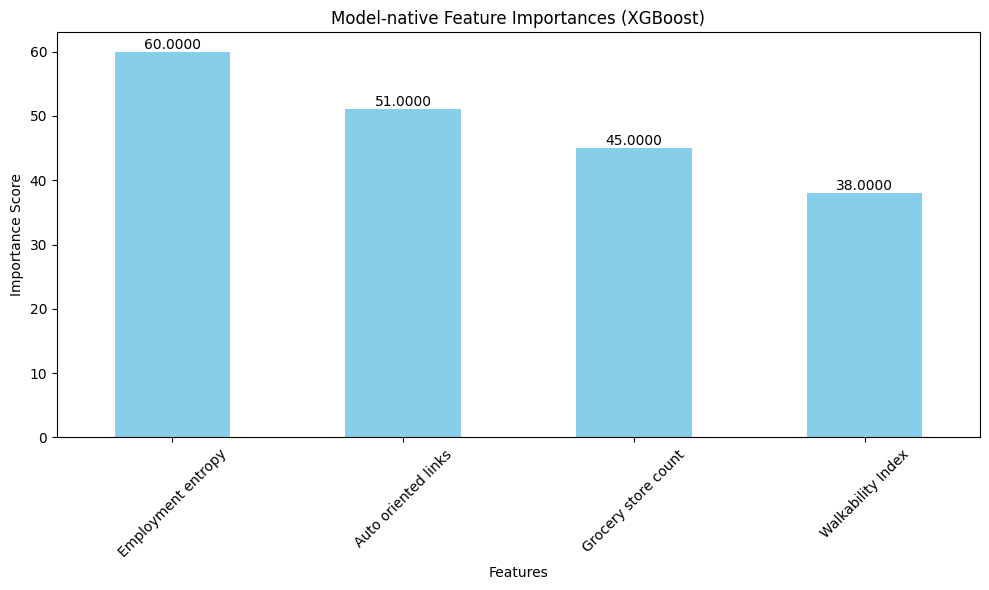


SHAP summary for South:

               feature  mean_abs_shap_value
1   Employment entropy             0.214477
3    Walkability Index             0.166066
0  Grocery store count             0.117006
2  Auto oriented links             0.046913

Training XGBoost model for region: West
Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 4, 'eta': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.8}
[0]	Validation-rmse:1.20007
[1]	Validation-rmse:1.19327
[2]	Validation-rmse:1.23382
[3]	Validation-rmse:1.23910
[4]	Validation-rmse:1.24644
[5]	Validation-rmse:1.24622
[6]	Validation-rmse:1.28050
[7]	Validation-rmse:1.30861
[8]	Validation-rmse:1.30057
[9]	Validation-rmse:1.27846
[10]	Validation-rmse:1.29030
[11]	Validation-rmse:1.27608
Validation RMSE: 1.2761
Validation R²: -0.1736
Test Set Performance:
RMSE: 1.0818
R² Score: 0.3563
MAE: 0.8054
AIC: 78.0981


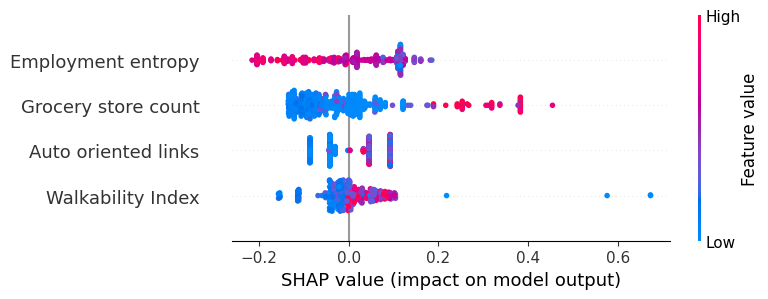

<Figure size 1000x600 with 0 Axes>

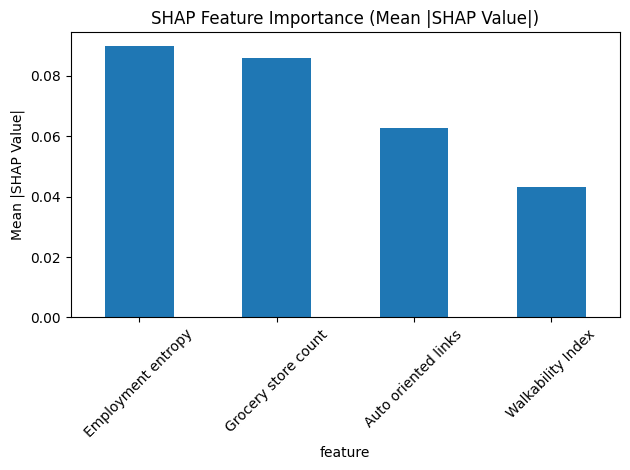

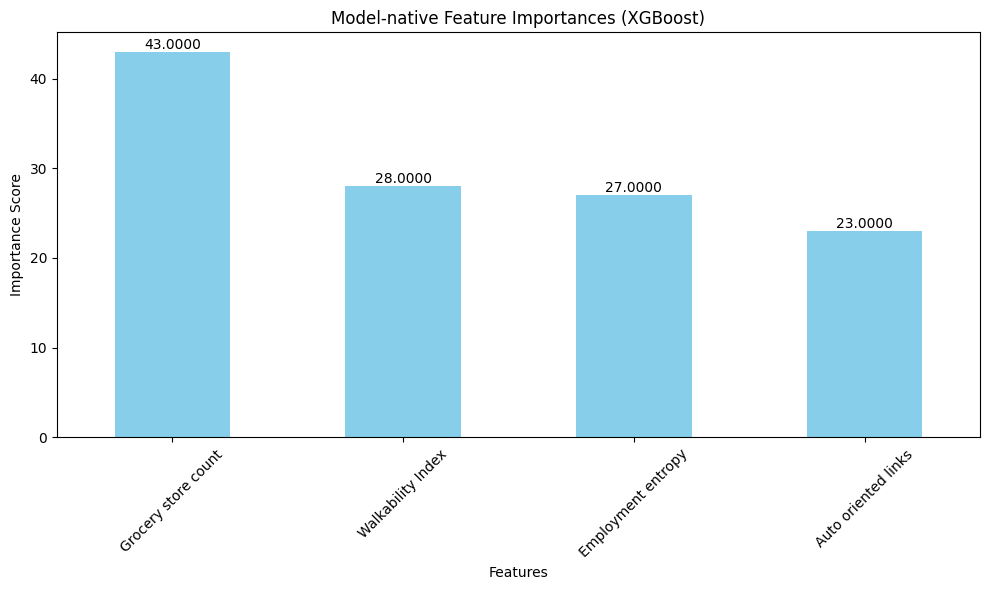


SHAP summary for West:

               feature  mean_abs_shap_value
1   Employment entropy             0.089911
0  Grocery store count             0.085763
2  Auto oriented links             0.062563
3    Walkability Index             0.043059

Model training, evaluation, and SHAP analysis complete for all regions.


In [270]:
# List of region-specific dataframes
regions = [northeast_df, midwest_df, south_df, west_df]
region_names = ["Northeast", "Midwest", "South", "West"]

# Empty dictionary to store results
results = {}

# Loop through each region's dataframe
for region_df, region_name in zip(regions, region_names):
    print(f"\nTraining XGBoost model for region: {region_name}")

    # Train model for the region
    region_results = train_xgboost_model(region_df, built_environment_features)

    # Test the model on test data
    X_test = region_df[built_environment_features]
    y_test = region_df['Prevalence']
    test_xgboost_model(region_results['model'], X_test, y_test)

    # Plot SHAP feature importance and capture the table
    shap_table = plot_shap_values(region_results['model'], X_test)

    # Store results for each region
    region_results["shap_table"] = shap_table
    results[region_name] = region_results

    # Print SHAP summary table
    print(f"\nSHAP summary for {region_name}:\n")
    print(shap_table)

# Final message
print("\nModel training, evaluation, and SHAP analysis complete for all regions.")


# Regional XGBoost with SVI subset


Training XGBoost model for region: Northeast
Best Hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': 4, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0}
[0]	Validation-rmse:1.41003
[1]	Validation-rmse:1.37294
[2]	Validation-rmse:1.33772
[3]	Validation-rmse:1.29697
[4]	Validation-rmse:1.25999
[5]	Validation-rmse:1.23353
[6]	Validation-rmse:1.20432
[7]	Validation-rmse:1.17606
[8]	Validation-rmse:1.14192
[9]	Validation-rmse:1.11436
[10]	Validation-rmse:1.08324
[11]	Validation-rmse:1.05939
[12]	Validation-rmse:1.03019
[13]	Validation-rmse:1.00525
[14]	Validation-rmse:0.98661
[15]	Validation-rmse:0.96163
[16]	Validation-rmse:0.94056
[17]	Validation-rmse:0.91893
[18]	Validation-rmse:0.90195
[19]	Validation-rmse:0.89179
[20]	Validation-rmse:0.87075
[21]	Validation-rmse:0.85908
[22]	Validation-rmse:0.84439
[23]	Validation-rmse:0.82786
[24]	Validation-rmse:0.81062
[25]	Validation-rmse:0.79199
[26]	Validation-rmse:0.77572
[27]	Validation-rmse:0.76668
[

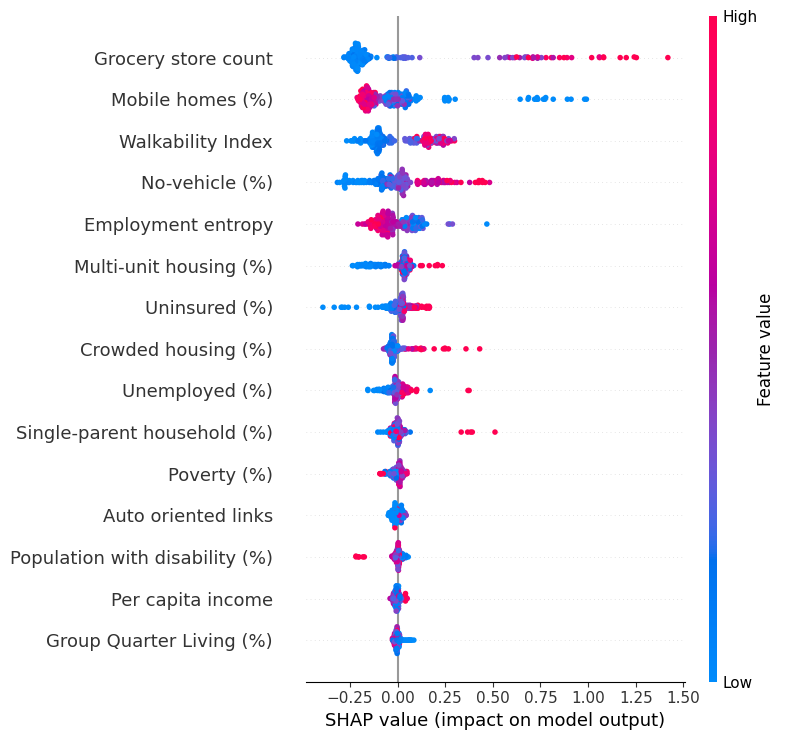

<Figure size 1000x600 with 0 Axes>

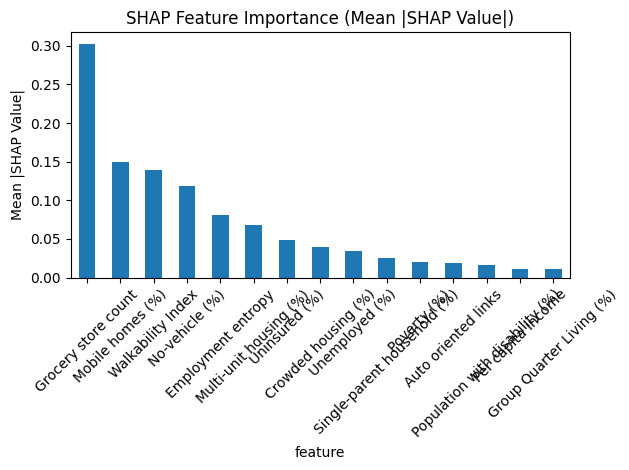

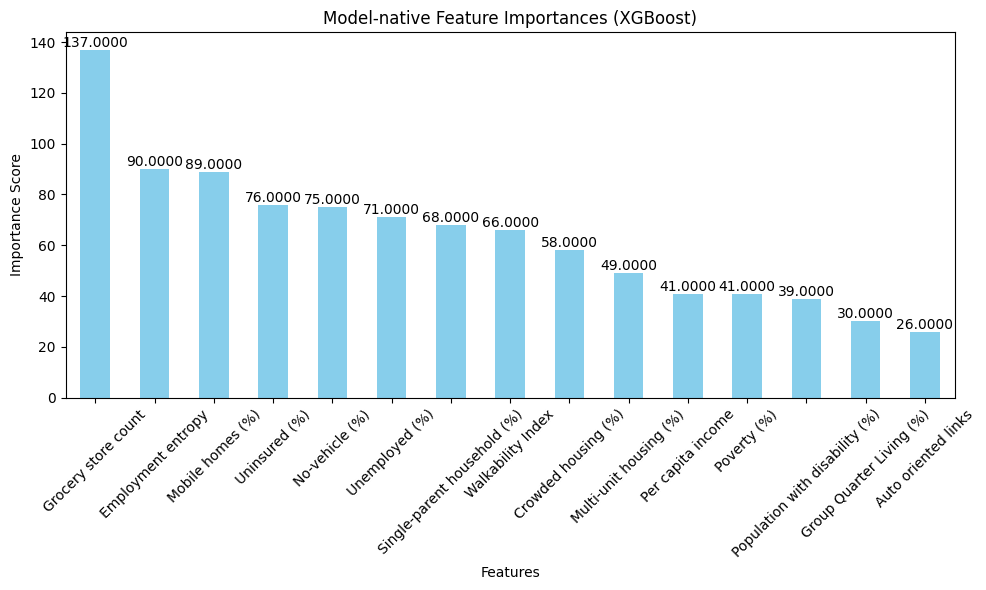


SHAP summary for Northeast:

                           feature  mean_abs_shap_value
0              Grocery store count             0.302196
10                Mobile homes (%)             0.149140
3                Walkability Index             0.139489
12                  No-vehicle (%)             0.118474
1               Employment entropy             0.080726
9           Multi-unit housing (%)             0.067661
14                   Uninsured (%)             0.048723
11             Crowded housing (%)             0.039456
4                   Unemployed (%)             0.035055
8      Single-parent household (%)             0.025766
6                      Poverty (%)             0.020109
2              Auto oriented links             0.018980
7   Population with disability (%)             0.016055
5                Per capita income             0.011443
13        Group Quarter Living (%)             0.011031

Training XGBoost model for region: Midwest
Best Hyperparameters: {'object

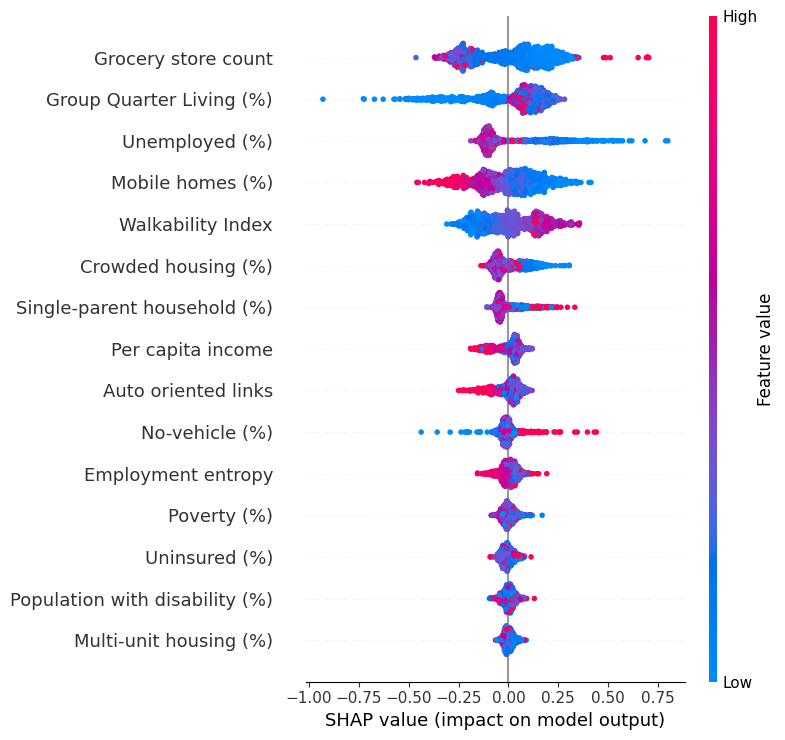

<Figure size 1000x600 with 0 Axes>

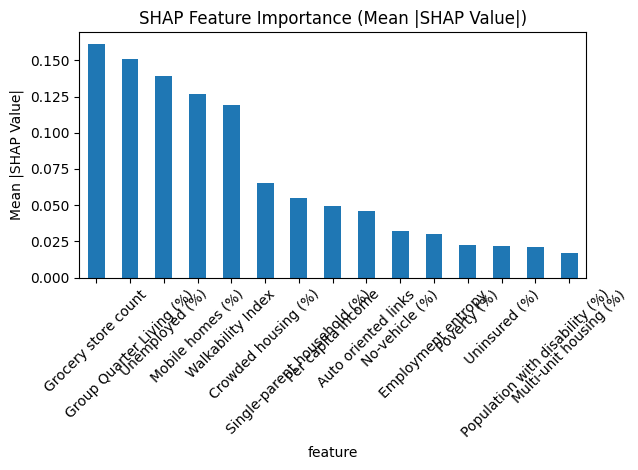

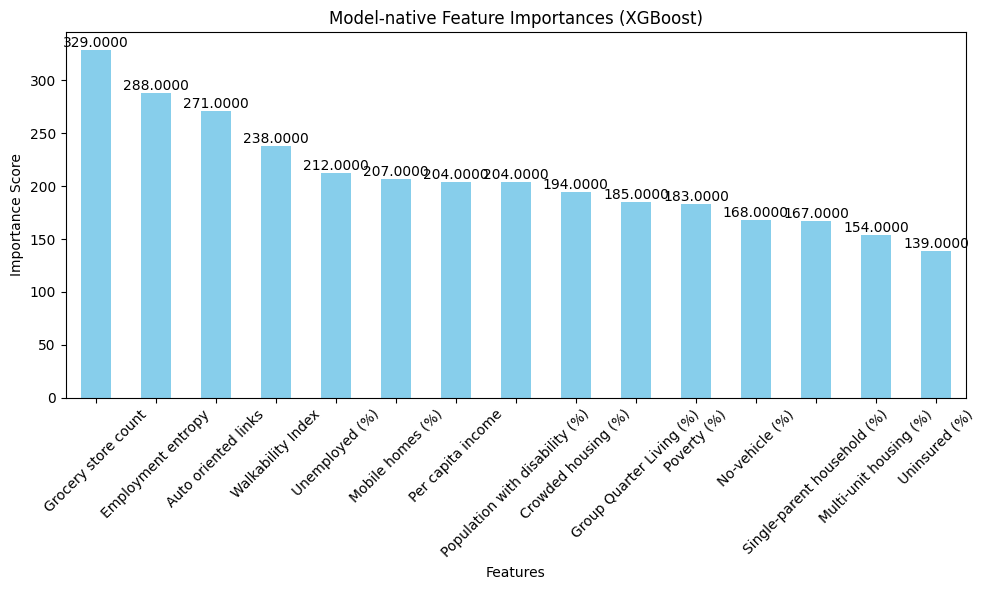


SHAP summary for Midwest:

                           feature  mean_abs_shap_value
0              Grocery store count             0.161245
13        Group Quarter Living (%)             0.150734
4                   Unemployed (%)             0.139512
10                Mobile homes (%)             0.126833
3                Walkability Index             0.119129
11             Crowded housing (%)             0.065444
8      Single-parent household (%)             0.054952
5                Per capita income             0.049319
2              Auto oriented links             0.046124
12                  No-vehicle (%)             0.032130
1               Employment entropy             0.030448
6                      Poverty (%)             0.022315
14                   Uninsured (%)             0.022090
7   Population with disability (%)             0.020974
9           Multi-unit housing (%)             0.016690

Training XGBoost model for region: South
Best Hyperparameters: {'objective'

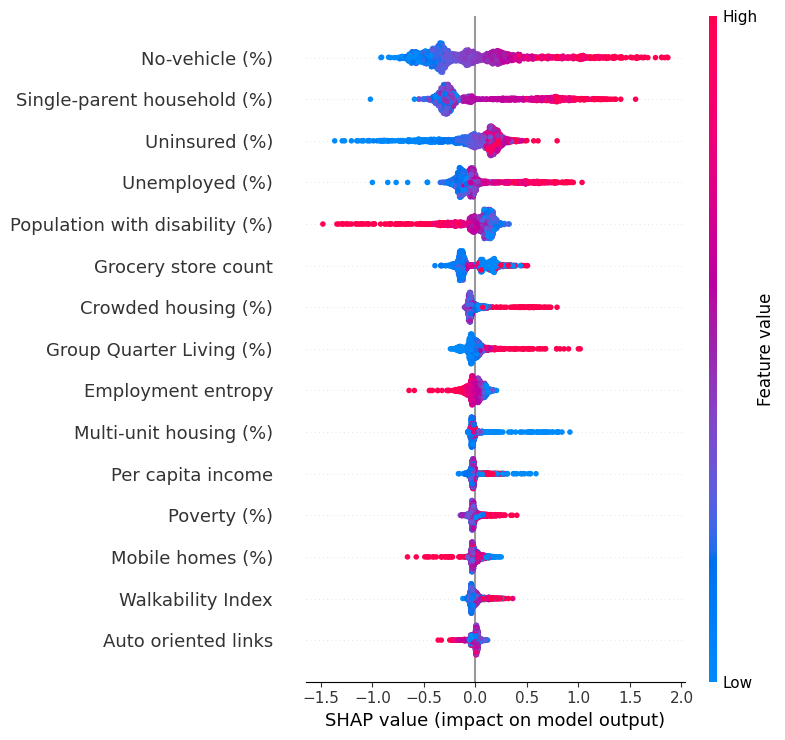

<Figure size 1000x600 with 0 Axes>

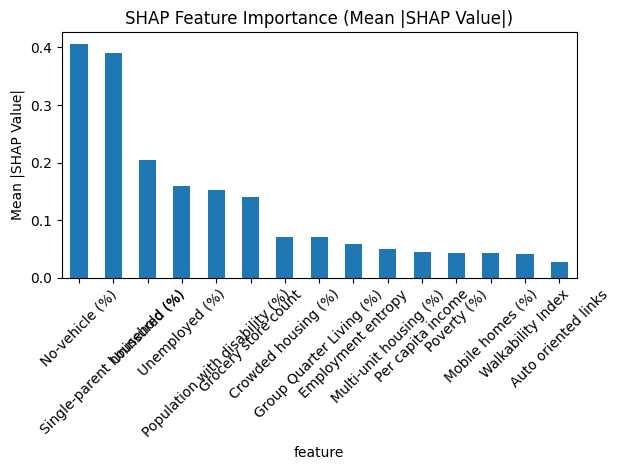

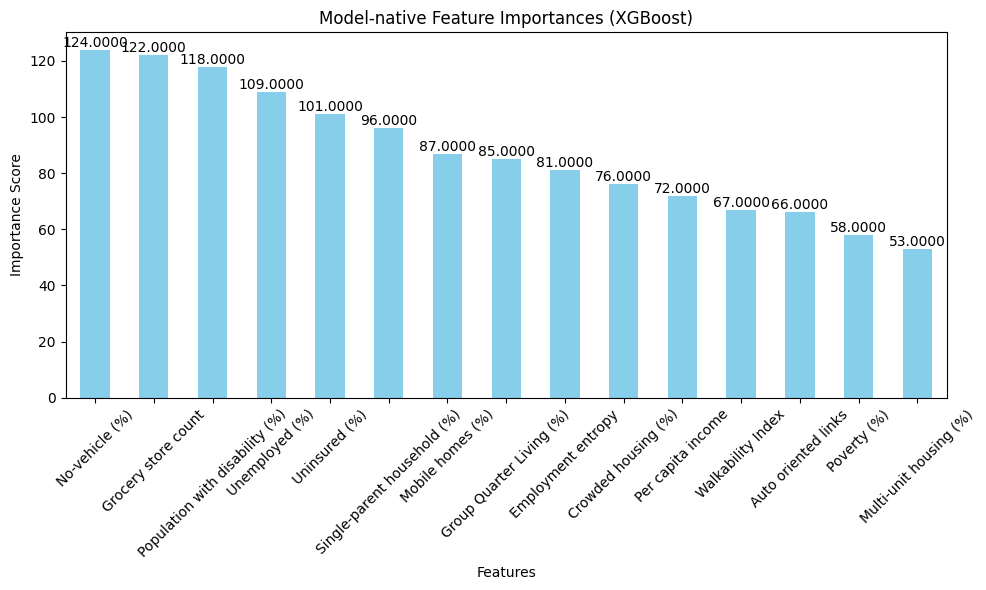


SHAP summary for South:

                           feature  mean_abs_shap_value
12                  No-vehicle (%)             0.406058
8      Single-parent household (%)             0.390967
14                   Uninsured (%)             0.205260
4                   Unemployed (%)             0.159835
7   Population with disability (%)             0.153143
0              Grocery store count             0.140425
11             Crowded housing (%)             0.071032
13        Group Quarter Living (%)             0.070870
1               Employment entropy             0.059091
9           Multi-unit housing (%)             0.049101
5                Per capita income             0.043809
6                      Poverty (%)             0.043464
10                Mobile homes (%)             0.042362
3                Walkability Index             0.041440
2              Auto oriented links             0.026731

Training XGBoost model for region: West
Best Hyperparameters: {'objective': '

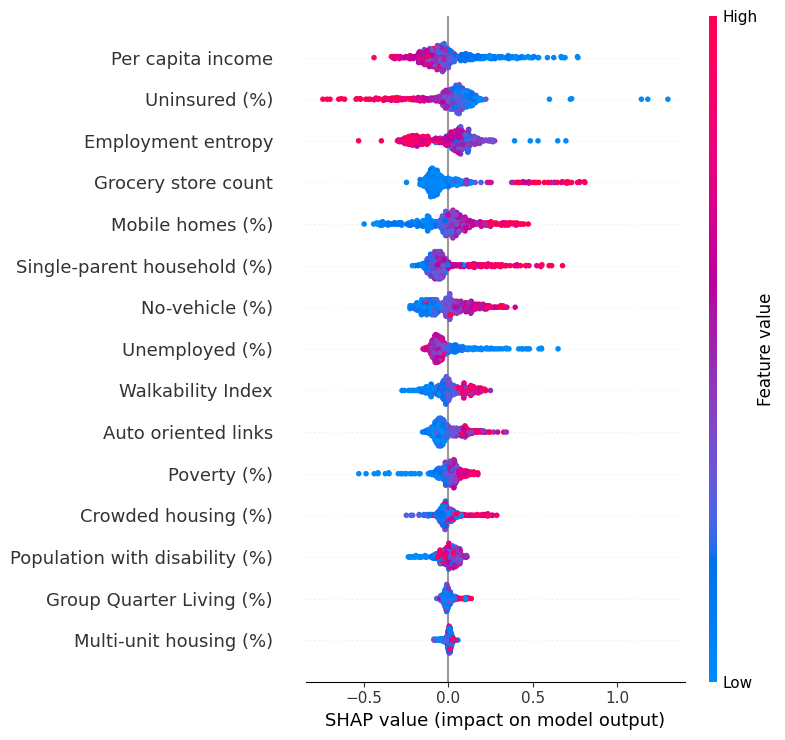

<Figure size 1000x600 with 0 Axes>

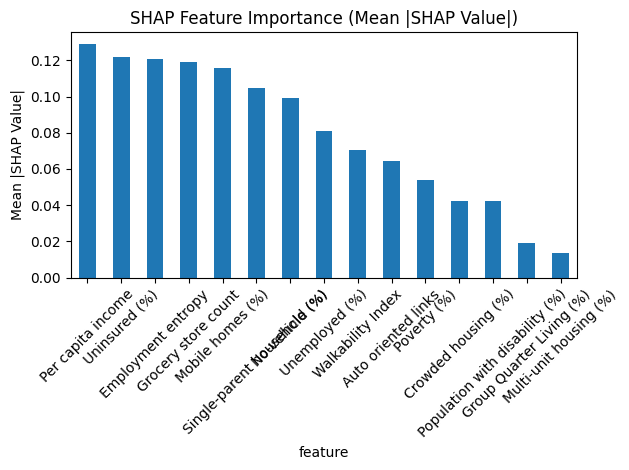

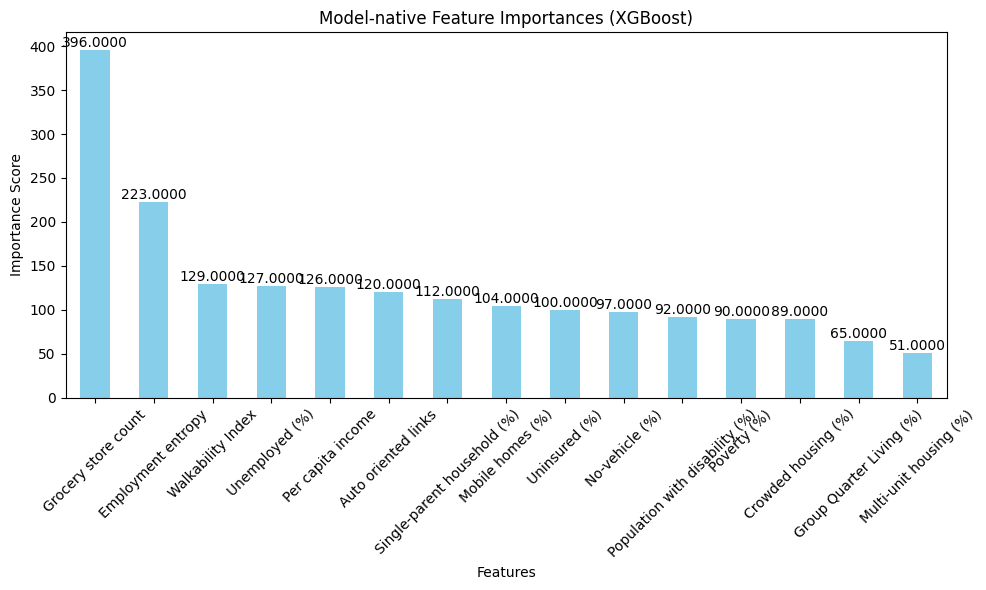


SHAP summary for West:

                           feature  mean_abs_shap_value
5                Per capita income             0.129012
14                   Uninsured (%)             0.121929
1               Employment entropy             0.120475
0              Grocery store count             0.118997
10                Mobile homes (%)             0.115633
8      Single-parent household (%)             0.104764
12                  No-vehicle (%)             0.099232
4                   Unemployed (%)             0.080713
3                Walkability Index             0.070542
2              Auto oriented links             0.064676
6                      Poverty (%)             0.054063
11             Crowded housing (%)             0.042293
7   Population with disability (%)             0.042275
13        Group Quarter Living (%)             0.018963
9           Multi-unit housing (%)             0.013743

Model training, evaluation, and SHAP analysis complete for all regions.


In [271]:
# List of region-specific dataframes
regions = [northeast_df, midwest_df, south_df, west_df]
region_names = ["Northeast", "Midwest", "South", "West"]

# Empty dictionary to store results
results = {}

# Loop through each region's dataframe
for region_df, region_name in zip(regions, region_names):
    print(f"\nTraining XGBoost model for region: {region_name}")

    # Train model for the region using BE + SVI variables
    region_results = train_xgboost_model(region_df, built_env_svi)

    # Test the model on test data
    X_test = region_df[built_env_svi]
    y_test = region_df['Prevalence']
    test_xgboost_model(region_results['model'], X_test, y_test)

    # Plot SHAP feature importance and capture the summary table
    shap_table = plot_shap_values(region_results['model'], X_test)

    # Store results and SHAP table
    region_results["shap_table"] = shap_table
    results[region_name] = region_results

    # Print SHAP summary table
    print(f"\nSHAP summary for {region_name}:\n")
    print(shap_table)

# Final message
print("\nModel training, evaluation, and SHAP analysis complete for all regions.")

# Random Forest with BE Only


Training Random Forest model for region: Northeast
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Validation RMSE (Random Forest): 0.6395
Validation R² (Random Forest): 0.8076
Test Set Performance (Random Forest):
RMSE: 0.5534
R² Score: 0.3129
MAE: 0.3624
AIC: 568.9511


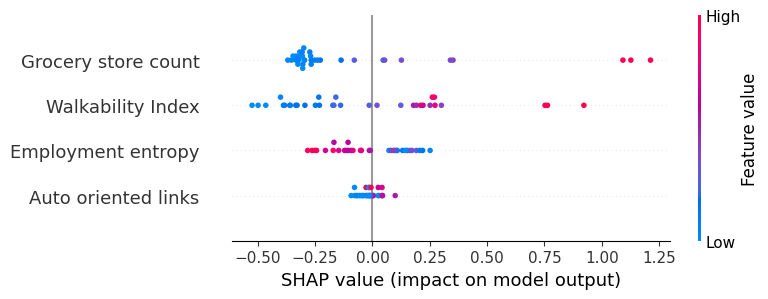


Top SHAP Feature Importances:
               feature  mean_abs_shap_value
0  Grocery store count             0.348167
1    Walkability Index             0.316536
2   Employment entropy             0.141342
3  Auto oriented links             0.035608


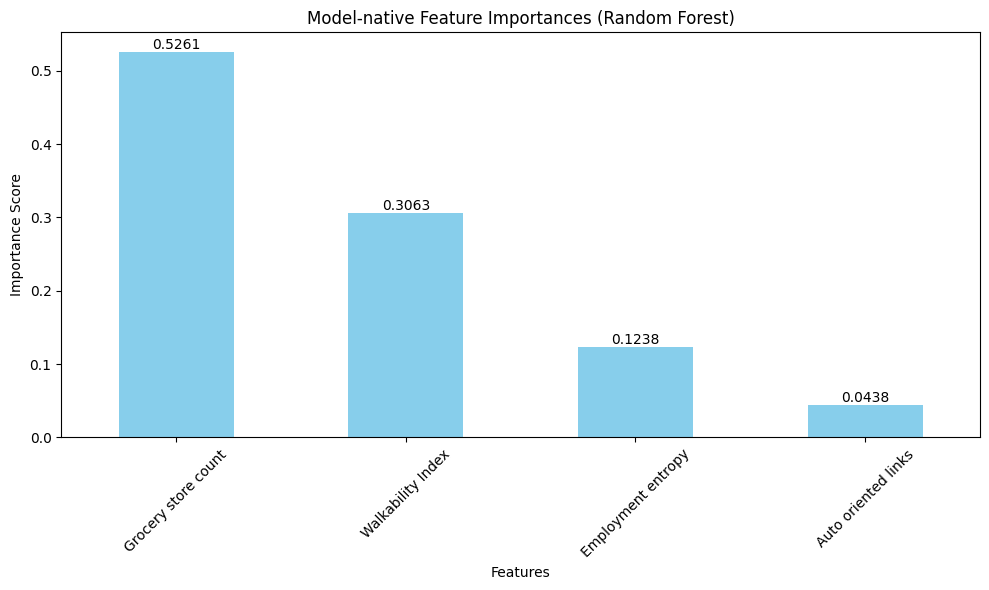


Training Random Forest model for region: Midwest
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Validation RMSE (Random Forest): 0.7691
Validation R² (Random Forest): 0.1989
Test Set Performance (Random Forest):
RMSE: 0.8637
R² Score: 0.1808
MAE: 0.6837
AIC: 561.4063


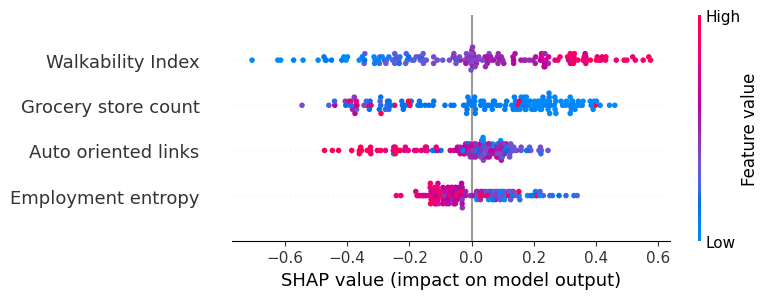


Top SHAP Feature Importances:
               feature  mean_abs_shap_value
0    Walkability Index             0.233543
1  Grocery store count             0.227234
2  Auto oriented links             0.114576
3   Employment entropy             0.100547


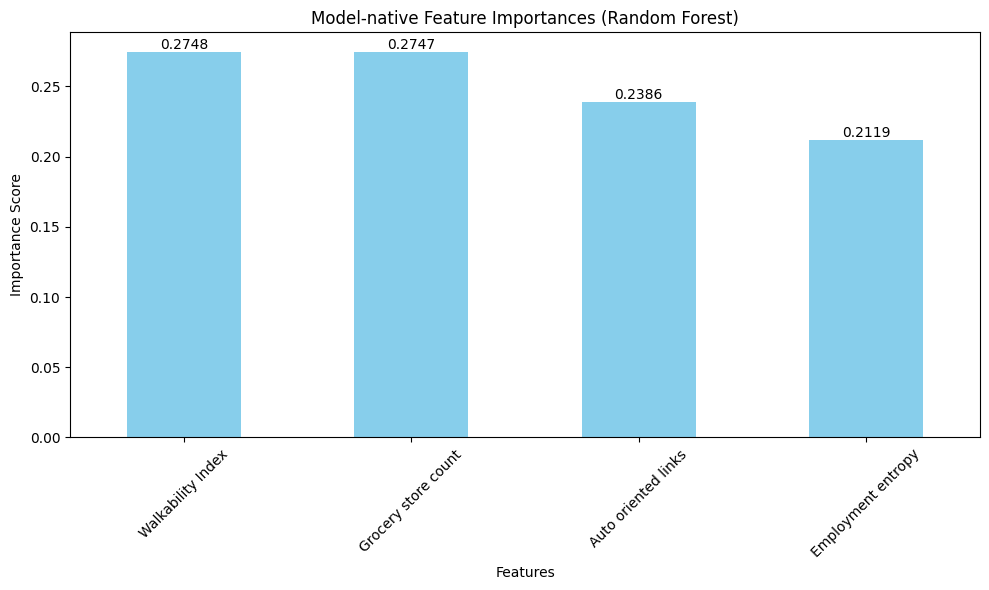


Training Random Forest model for region: South
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Validation RMSE (Random Forest): 1.5604
Validation R² (Random Forest): 0.0413
Test Set Performance (Random Forest):
RMSE: 1.6017
R² Score: 0.0505
MAE: 1.2053
AIC: 608.6734


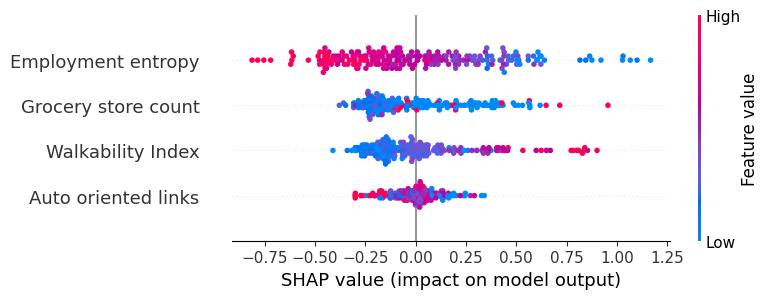


Top SHAP Feature Importances:
               feature  mean_abs_shap_value
0   Employment entropy             0.317411
1  Grocery store count             0.208760
2    Walkability Index             0.195385
3  Auto oriented links             0.086024


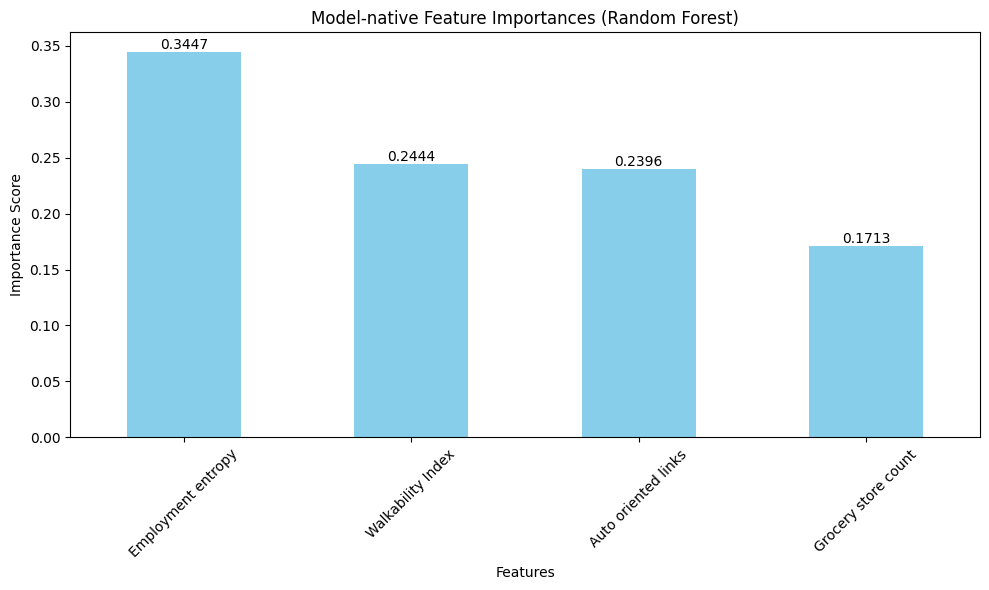


Training Random Forest model for region: West
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Validation RMSE (Random Forest): 1.2176
Validation R² (Random Forest): -0.0685
Test Set Performance (Random Forest):
RMSE: 1.1912
R² Score: 0.1808
MAE: 0.9277
AIC: 431.4468


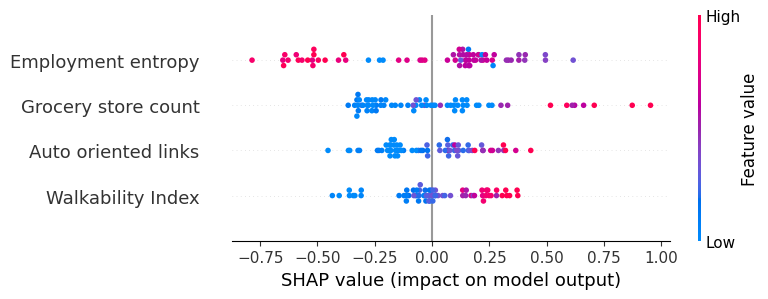


Top SHAP Feature Importances:
               feature  mean_abs_shap_value
0   Employment entropy             0.304600
1  Grocery store count             0.246079
2  Auto oriented links             0.170254
3    Walkability Index             0.152233


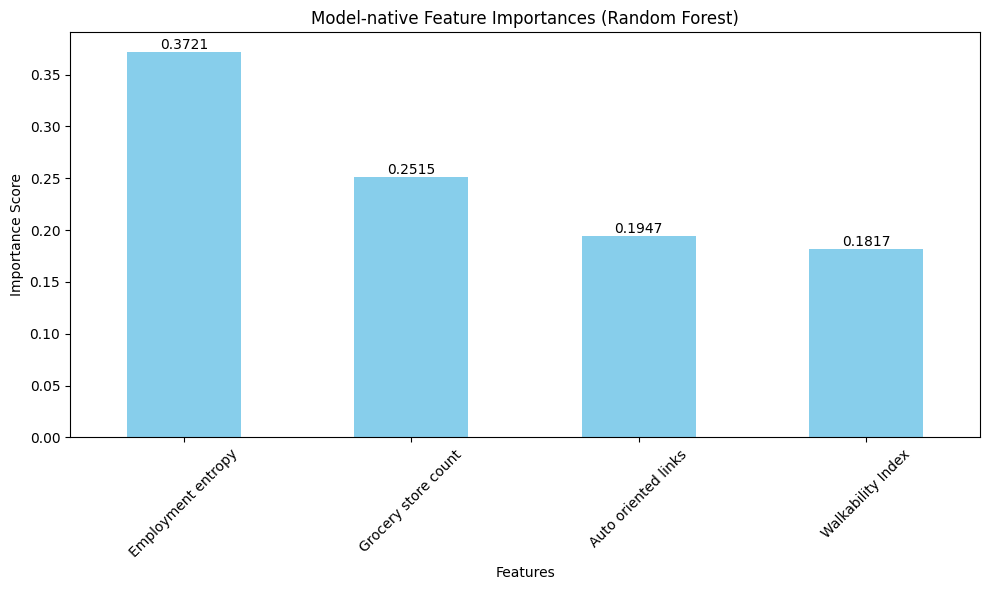


Random Forest model training and evaluation complete for all regions.


In [272]:
# List of region-specific dataframes
regions = [northeast_df, midwest_df, south_df, west_df]
region_names = ["Northeast", "Midwest", "South", "West"]

# Dictionary to store results for each region
rf_results = {}

# Loop through each region's dataframe and train Random Forest model
for region_df, region_name in zip(regions, region_names):
    print(f"\nTraining Random Forest model for region: {region_name}")

    # Ensure no missing values in features
    region_df = region_df.dropna(subset=built_environment_features + ['Prevalence'])

    # Train Random Forest model
    region_results = train_random_forest_model(region_df, built_environment_features)

    # Test the trained model
    test_random_forest_model(region_results['model'], region_results['X_test'], region_results['y_test'])

    # Compute SHAP feature importance
    shap_feature_importance_rf(region_results['model'], region_results['X_test'], built_environment_features)

    # Store results
    rf_results[region_name] = region_results

# Print completion message
print("\nRandom Forest model training and evaluation complete for all regions.")


# Regional Random Forest with SVI subset


Training Random Forest model for region: Northeast
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Validation RMSE (Random Forest): 0.6322
Validation R² (Random Forest): 0.8120
Test Set Performance (Random Forest):
RMSE: 0.4738
R² Score: 0.4964
MAE: 0.3524
AIC: 180.6998


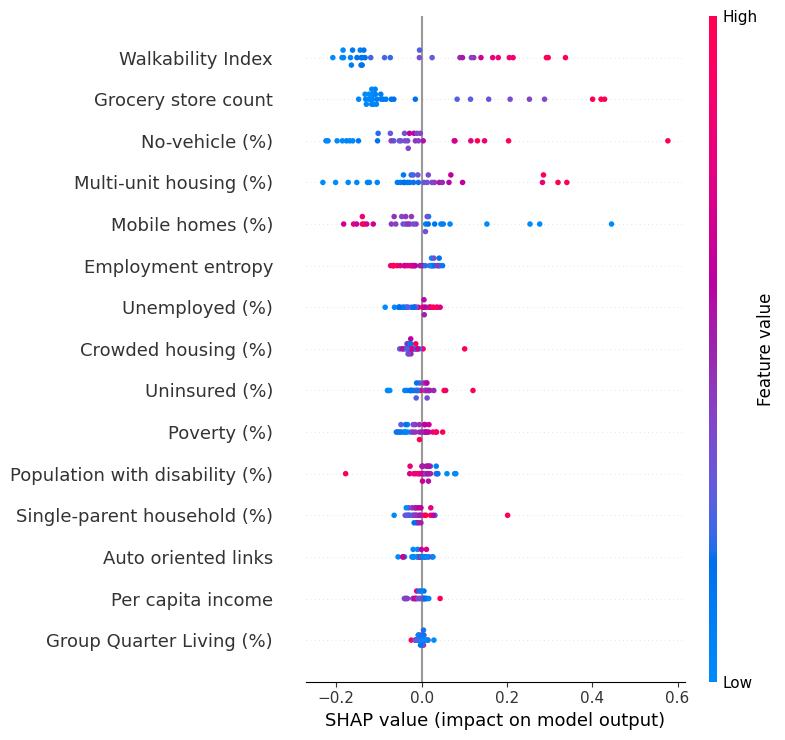


Top SHAP Feature Importances:
                           feature  mean_abs_shap_value
0                Walkability Index             0.150049
1              Grocery store count             0.148297
2                   No-vehicle (%)             0.107737
3           Multi-unit housing (%)             0.094469
4                 Mobile homes (%)             0.091222
5               Employment entropy             0.032861
6                   Unemployed (%)             0.029169
7              Crowded housing (%)             0.028468
8                    Uninsured (%)             0.027013
9                      Poverty (%)             0.026688
10  Population with disability (%)             0.025550
11     Single-parent household (%)             0.024703
12             Auto oriented links             0.015199
13               Per capita income             0.014203
14        Group Quarter Living (%)             0.007488


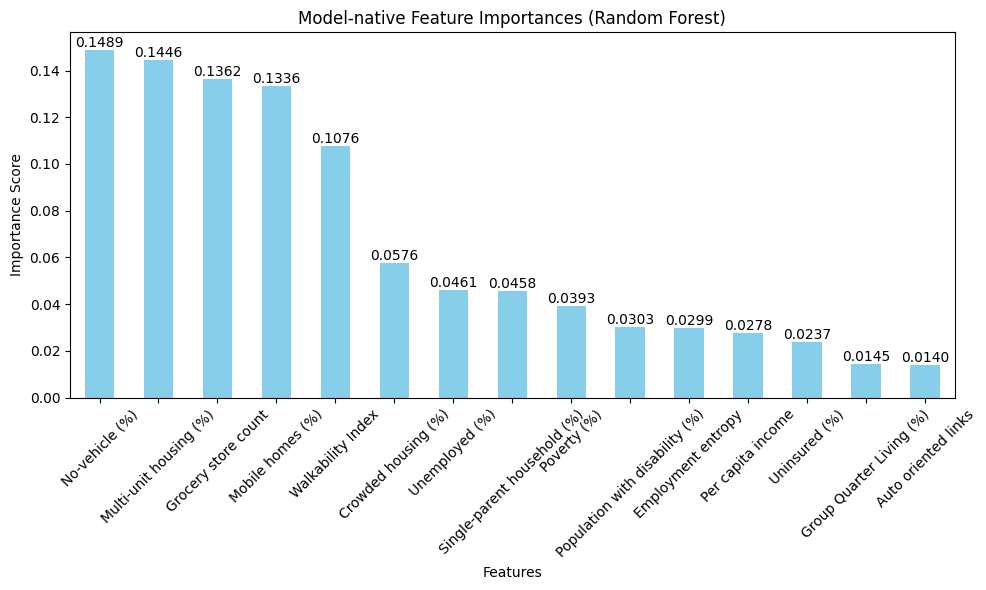


Training Random Forest model for region: Midwest
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Validation RMSE (Random Forest): 0.6876
Validation R² (Random Forest): 0.3596
Test Set Performance (Random Forest):
RMSE: 0.7773
R² Score: 0.3366
MAE: 0.5965
AIC: 549.8737


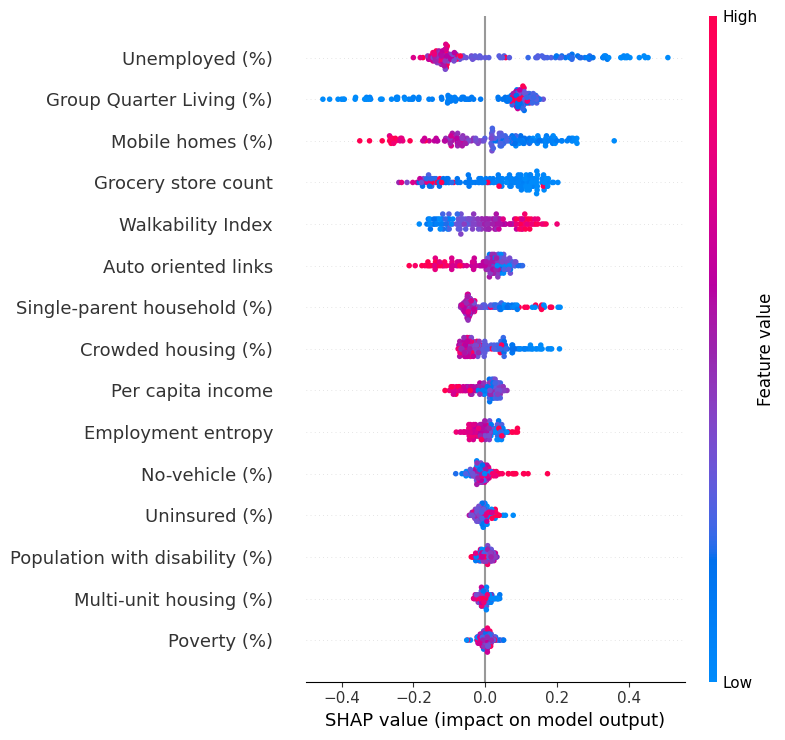


Top SHAP Feature Importances:
                           feature  mean_abs_shap_value
0                   Unemployed (%)             0.160528
1         Group Quarter Living (%)             0.134844
2                 Mobile homes (%)             0.117675
3              Grocery store count             0.107685
4                Walkability Index             0.077860
5              Auto oriented links             0.057756
6      Single-parent household (%)             0.056629
7              Crowded housing (%)             0.053980
8                Per capita income             0.034541
9               Employment entropy             0.027414
10                  No-vehicle (%)             0.023575
11                   Uninsured (%)             0.015892
12  Population with disability (%)             0.012902
13          Multi-unit housing (%)             0.011946
14                     Poverty (%)             0.011821


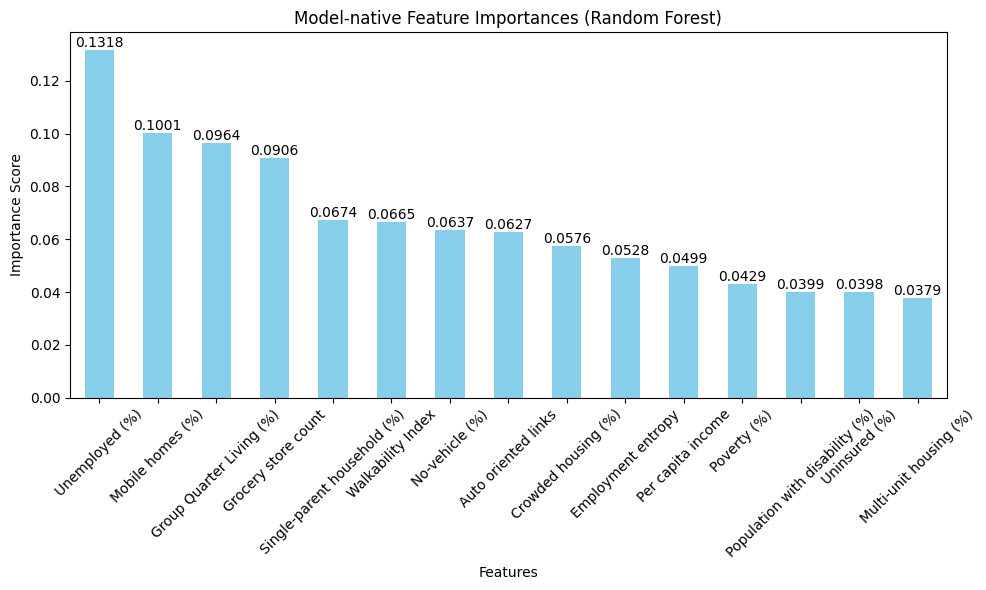


Training Random Forest model for region: South
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Validation RMSE (Random Forest): 1.0756
Validation R² (Random Forest): 0.5445
Test Set Performance (Random Forest):
RMSE: 1.0195
R² Score: 0.6153
MAE: 0.7809
AIC: 638.2243


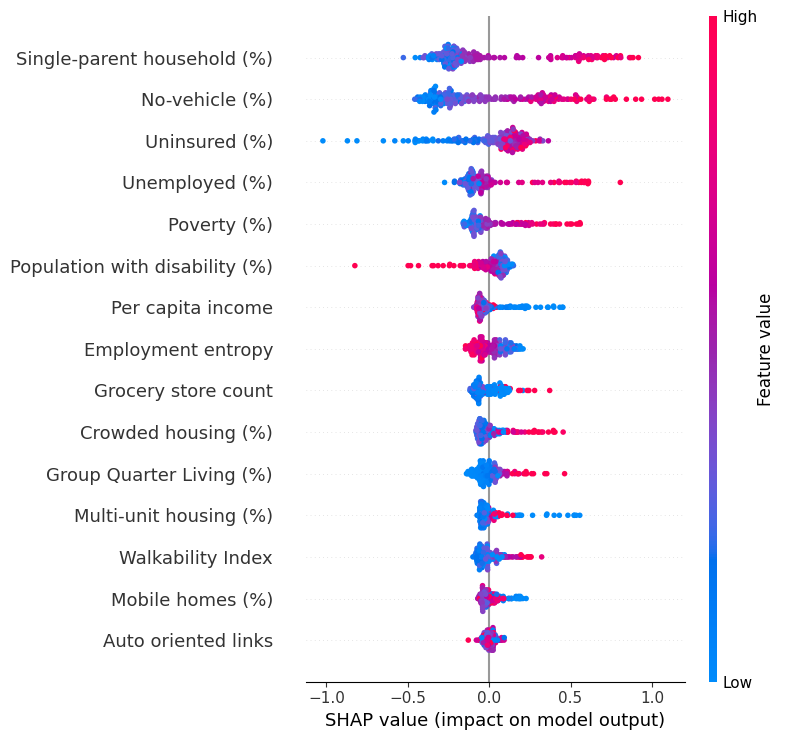


Top SHAP Feature Importances:
                           feature  mean_abs_shap_value
0      Single-parent household (%)             0.317927
1                   No-vehicle (%)             0.315187
2                    Uninsured (%)             0.175154
3                   Unemployed (%)             0.133579
4                      Poverty (%)             0.114434
5   Population with disability (%)             0.082736
6                Per capita income             0.073185
7               Employment entropy             0.070689
8              Grocery store count             0.070022
9              Crowded housing (%)             0.065194
10        Group Quarter Living (%)             0.059411
11          Multi-unit housing (%)             0.056936
12               Walkability Index             0.056589
13                Mobile homes (%)             0.042831
14             Auto oriented links             0.022520


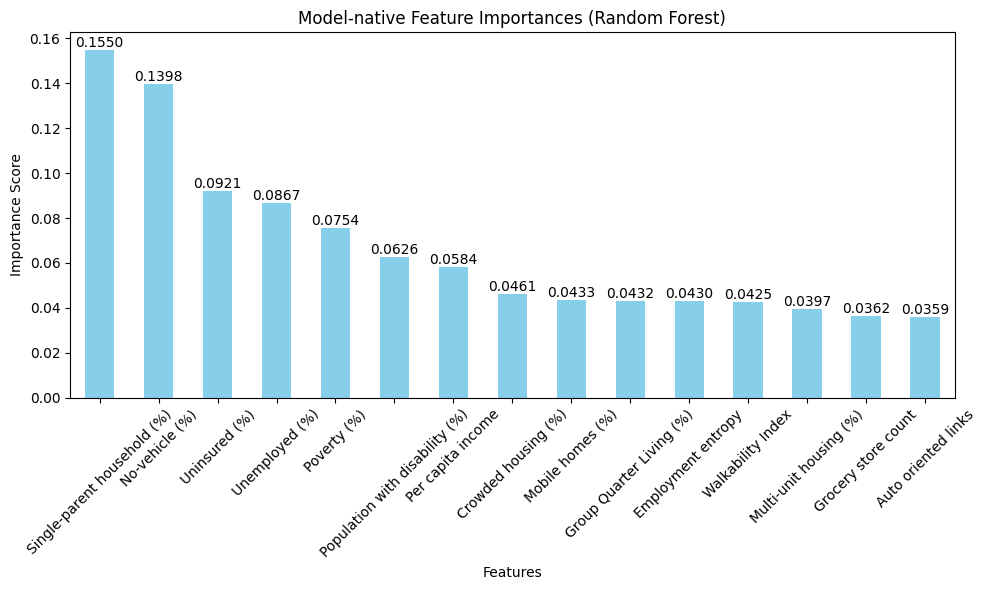


Training Random Forest model for region: West
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Validation RMSE (Random Forest): 0.9457
Validation R² (Random Forest): 0.3555
Test Set Performance (Random Forest):
RMSE: 1.0045
R² Score: 0.4175
MAE: 0.7598
AIC: 630.5954


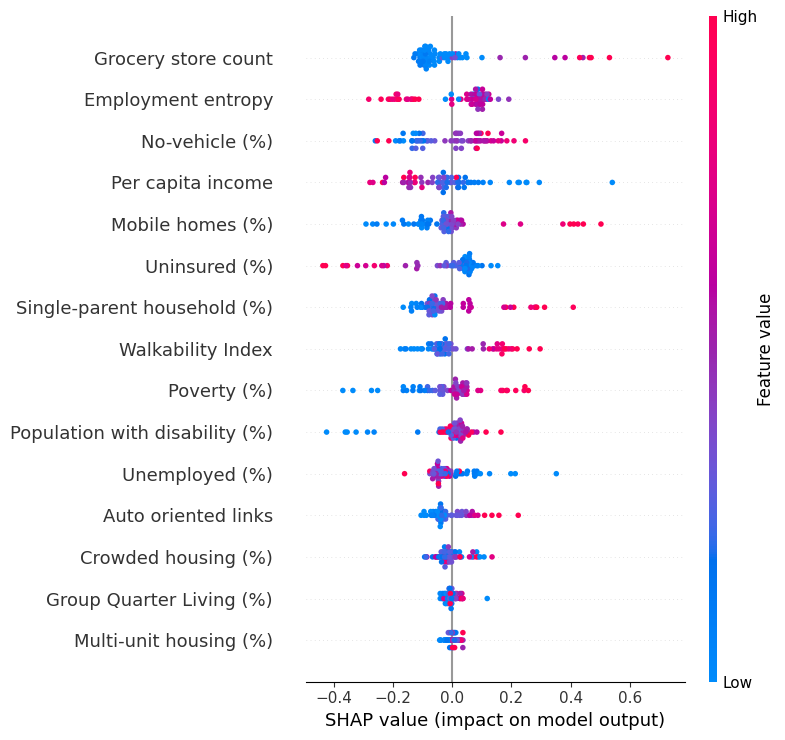


Top SHAP Feature Importances:
                           feature  mean_abs_shap_value
0              Grocery store count             0.118840
1               Employment entropy             0.109092
2                   No-vehicle (%)             0.104633
3                Per capita income             0.103744
4                 Mobile homes (%)             0.100541
5                    Uninsured (%)             0.097871
6      Single-parent household (%)             0.094721
7                Walkability Index             0.090375
8                      Poverty (%)             0.085787
9   Population with disability (%)             0.059006
10                  Unemployed (%)             0.053611
11             Auto oriented links             0.052633
12             Crowded housing (%)             0.034444
13        Group Quarter Living (%)             0.016972
14          Multi-unit housing (%)             0.014139


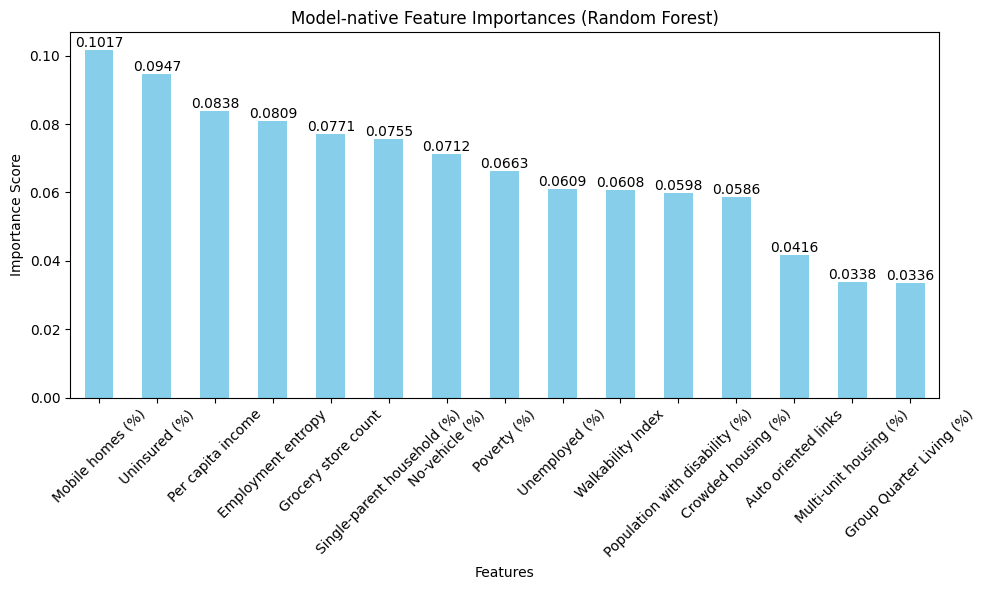


Random Forest model training and evaluation complete for all regions.


In [273]:
# List of region-specific dataframes
regions = [northeast_df, midwest_df, south_df, west_df]
region_names = ["Northeast", "Midwest", "South", "West"]

# Dictionary to store results for each region
rf_results = {}

# Loop through each region's dataframe and train Random Forest model
for region_df, region_name in zip(regions, region_names):
    print(f"\nTraining Random Forest model for region: {region_name}")

    # Ensure no missing values in features
    region_df = region_df.dropna(subset=built_env_svi + ['Prevalence'])

    # Train Random Forest model
    region_results = train_random_forest_model(region_df, built_env_svi)

    # Test the trained model
    test_random_forest_model(region_results['model'], region_results['X_test'], region_results['y_test'])

    # Compute SHAP feature importance
    shap_feature_importance_rf(region_results['model'], region_results['X_test'], built_env_svi)

    # Store results
    rf_results[region_name] = region_results

# Print completion message
print("\nRandom Forest model training and evaluation complete for all regions.")


# Anova

## Do regions vary in mean prevalence?

In [274]:
import scipy.stats as stats
# Grouping prevalence data by region
northeast = merged_data[merged_data['region'] == 'Northeast']['Prevalence']
south = merged_data[merged_data['region'] == 'South']['Prevalence']
midwest = merged_data[merged_data['region'] == 'Midwest']['Prevalence']
west = merged_data[merged_data['region'] == 'West']['Prevalence']

# Performing ANOVA test
f_stat, p_value = stats.f_oneway(northeast, south, midwest, west)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

F-statistic: 126.5627
P-value: 0.0000


In [275]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Performing Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=merged_data['Prevalence'],  
                                  groups=merged_data['region'],   
                                  alpha=0.05)  # 95% confidence level

# Displaying the results
print(tukey_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0646 0.9211 -0.3266  0.1974  False
  Midwest     South   0.6932    0.0  0.5503   0.836   True
  Midwest      West  -0.6314    0.0 -0.8299 -0.4329   True
Northeast     South   0.7578    0.0  0.5016   1.014   True
Northeast      West  -0.5668    0.0 -0.8577 -0.2759   True
    South      West  -1.3246    0.0 -1.5154 -1.1338   True
----------------------------------------------------------


# Does Prevalence vary by RUCC category?

In [276]:
merged_data['RUCC_5_categories'] = merged_data['RUCC_2013'].apply(lambda x: 
                                             "Large Metro" if x == 1 else
                                             "Medium Metro" if x == 2 else
                                             "Small Metro" if x == 3 else
                                             "Urban Non-Metro" if 4 <= x <= 7 else
                                             "Rural Non-Metro" if 8 <= x <= 9 else 
                                             None)
full_merged_data = merged_data.dropna(subset=['RUCC_2013'])

In [277]:
# Grouping prevalence data by RUCC_5_categories
large_metro = full_merged_data[full_merged_data['RUCC_5_categories'] == 'Large Metro']['Prevalence']
medium_metro = full_merged_data[full_merged_data['RUCC_5_categories'] == 'Medium Metro']['Prevalence']
small_metro = full_merged_data[full_merged_data['RUCC_5_categories'] == 'Small Metro']['Prevalence']
urban_non_metro = full_merged_data[full_merged_data['RUCC_5_categories'] == 'Urban Non-Metro']['Prevalence']
rural_non_metro = full_merged_data[full_merged_data['RUCC_5_categories'] == 'Rural Non-Metro']['Prevalence']

# Performing ANOVA test
f_stat, p_value = stats.f_oneway(large_metro, medium_metro, small_metro, urban_non_metro, rural_non_metro)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

F-statistic: 1.2519
P-value: 0.2867


In [278]:
# Performing Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=full_merged_data['Prevalence'],  
                                  groups=full_merged_data['RUCC_5_categories'],   
                                  alpha=0.05)  # 95% confidence level

# Displaying the results
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
    Large Metro    Medium Metro  -0.0448 0.9923 -0.3228 0.2332  False
    Large Metro Rural Non-Metro   0.0673 0.9451 -0.1784  0.313  False
    Large Metro     Small Metro  -0.1162  0.795  -0.399 0.1665  False
    Large Metro Urban Non-Metro   0.0444 0.9815 -0.1743  0.263  False
   Medium Metro Rural Non-Metro   0.1121 0.7537 -0.1437 0.3678  False
   Medium Metro     Small Metro  -0.0715  0.963  -0.363 0.2201  False
   Medium Metro Urban Non-Metro   0.0891  0.828 -0.1408 0.3191  False
Rural Non-Metro     Small Metro  -0.1835 0.3068 -0.4445 0.0774  False
Rural Non-Metro Urban Non-Metro  -0.0229 0.9974 -0.2125 0.1666  False
    Small Metro Urban Non-Metro   0.1606 0.3394 -0.0751 0.3963  False
---------------------------------------------------------------------


# Do rural/urban areas differ within certain regions?

In [279]:
# Define regions
regions = ['Northeast', 'South', 'Midwest', 'West']

# Loop through each region and perform ANOVA + Tukey's HSD
for region in regions:
    print(f"\n--- {region} ---")
    
    # Subset data for the current region
    region_data = full_merged_data[full_merged_data['region'] == region].copy()

    # Drop NaN values in Prevalence
    region_data = region_data.dropna(subset=['Prevalence'])

    # Ensure enough unique groups (remove categories with only one value)
    valid_categories = region_data['RUCC_5_categories'].value_counts()[lambda x: x > 1].index
    region_data = region_data[region_data['RUCC_5_categories'].isin(valid_categories)]
    
    if region_data['RUCC_5_categories'].nunique() > 1:
        # Group prevalence data correctly *within the region*
        groups = [region_data[region_data['RUCC_5_categories'] == category]['Prevalence']
                  for category in region_data['RUCC_5_categories'].unique()]
        
        # ANOVA Test
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"ANOVA F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
        
        # If ANOVA is significant, perform Tukey's HSD test
        if p_value < 0.05:
            tukey_results = pairwise_tukeyhsd(endog=region_data['Prevalence'],  
                                              groups=region_data['RUCC_5_categories'],   
                                              alpha=0.05)
            print(tukey_results)
        else:
            print("No significant differences between rural/urban categories in this region.")
    else:
        print("Not enough valid rural/urban categories for ANOVA in this region.")



--- Northeast ---
ANOVA F-statistic: 23.0351, P-value: 0.0000
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
    Large Metro    Medium Metro  -0.7562 0.0008 -1.2732 -0.2391   True
    Large Metro Rural Non-Metro  -1.8462    0.0 -2.7201 -0.9722   True
    Large Metro     Small Metro  -1.0862    0.0 -1.6917 -0.4806   True
    Large Metro Urban Non-Metro  -1.3841    0.0 -1.8175 -0.9507   True
   Medium Metro Rural Non-Metro    -1.09   0.01 -1.9997 -0.1803   True
   Medium Metro     Small Metro    -0.33 0.6385  -0.986   0.326  False
   Medium Metro Urban Non-Metro  -0.6279 0.0061 -1.1294 -0.1264   True
Rural Non-Metro     Small Metro     0.76 0.1944 -0.2027  1.7227  False
Rural Non-Metro Urban Non-Metro   0.4621 0.5831 -0.4028  1.3269  False
    Small Metro Urban Non-Metro  -0.2979 0.6386 -0.8902  0.2943  False
--------------

In [294]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Define regions
regions = ['Northeast', 'South', 'Midwest', 'West']

# Initialize dictionary to store results
anova_results = []
tukey_results_dict = {}

# Loop through each region
for region in regions:
    # Subset and clean data
    region_data = full_merged_data[full_merged_data['region'] == region].copy()
    region_data = region_data.dropna(subset=['Prevalence'])

    # Remove categories with only one value
    valid_categories = region_data['RUCC_5_categories'].value_counts()[lambda x: x > 1].index
    region_data = region_data[region_data['RUCC_5_categories'].isin(valid_categories)]

    # Ensure enough groups for ANOVA
    if region_data['RUCC_5_categories'].nunique() > 1:
        groups = [region_data[region_data['RUCC_5_categories'] == cat]['Prevalence']
                  for cat in region_data['RUCC_5_categories'].unique()]

        # Perform ANOVA
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results.append({
            'Region': region,
            'F-statistic': f_stat,
            'P-value': p_value
        })

        # Perform Tukey HSD if significant
        if p_value < 0.05:
            tukey = pairwise_tukeyhsd(endog=region_data['Prevalence'],
                                      groups=region_data['RUCC_5_categories'],
                                      alpha=0.05)
            tukey_df = pd.DataFrame(tukey._results_table.data[1:],  # skip header
                                    columns=tukey._results_table.data[0])
            tukey_results_dict[region] = tukey_df
        else:
            tukey_results_dict[region] = pd.DataFrame({'Note': ['No significant differences']})
    else:
        anova_results.append({
            'Region': region,
            'F-statistic': None,
            'P-value': None
        })
        tukey_results_dict[region] = pd.DataFrame({'Note': ['Not enough valid rural/urban categories']})

# Save to Excel
with pd.ExcelWriter("regional_anova_tukey_results.xlsx", engine='openpyxl') as writer:
    pd.DataFrame(anova_results).to_excel(writer, sheet_name="ANOVA Results", index=False)
    for region, tukey_df in tukey_results_dict.items():
        tukey_df.to_excel(writer, sheet_name=f"{region} Tukey HSD", index=False)

# Descriptive Statistics per region

In [280]:
# List of region dataframes
regions = [northeast_df, midwest_df, south_df, west_df]
region_names = ["Northeast", "Midwest", "South", "West"]

# Compute descriptive statistics
for df, name in zip(regions, region_names):
    print(f"Descriptive statistics for {name}:")
    print(f"Mean: {df['Prevalence'].mean():.4f}")
    print(f"Median: {df['Prevalence'].median():.4f}")
    print(f"Standard Deviation: {df['Prevalence'].std():.4f}")
    print(f"Min: {df['Prevalence'].min():.4f}")
    print(f"Max: {df['Prevalence'].max():.4f}")
    print(f"Range: {df['Prevalence'].max() - df['Prevalence'].min():.4f}")
    print(f"25th Percentile (Q1): {df['Prevalence'].quantile(0.25):.4f}")
    print(f"75th Percentile (Q3): {df['Prevalence'].quantile(0.75):.4f}")
    print("\n")


Descriptive statistics for Northeast:
Mean: 10.8654
Median: 10.6000
Standard Deviation: 1.1097
Min: 8.3000
Max: 16.6000
Range: 8.3000
25th Percentile (Q1): 10.2000
75th Percentile (Q3): 11.3000


Descriptive statistics for Midwest:
Mean: 10.9300
Median: 10.9000
Standard Deviation: 0.9188
Min: 7.3000
Max: 14.6000
Range: 7.3000
25th Percentile (Q1): 10.3000
75th Percentile (Q3): 11.5000


Descriptive statistics for South:
Mean: 11.6232
Median: 11.3000
Standard Deviation: 1.6563
Min: 5.6000
Max: 18.4000
Range: 12.8000
25th Percentile (Q1): 10.4000
75th Percentile (Q3): 12.6000


Descriptive statistics for West:
Mean: 10.2987
Median: 10.1000
Standard Deviation: 1.3498
Min: 6.7000
Max: 17.3000
Range: 10.6000
25th Percentile (Q1): 9.5000
75th Percentile (Q3): 11.1000




In [281]:
northeast_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery store count',
       'Grocery__1', 'Convenience store count', 'Conviene_1',
       'Residential density', 'Population density', 'Employment density',
       'Jobs per household', 'Employment entropy',
       'Pedestrian-oriented intersections (3 legs)', 'Job Equilibrium Index',
       'Road network density', 'Auto oriented links',
       'Pedestrian oriented links',
       'Pedestrian-oriented intersections (4 legs)',
       'Auto oriented intersections', 'Walkability Index',
       'Proportion of employment within transit', 'Jobs within 45 minutes',
       'Working age population within 45 minutes', 'Transit frequency',
       'Distance 

In [282]:
regions = [northeast_df, midwest_df, south_df, west_df]
region_names = ['Northeast', 'Midwest', 'South', 'West']

medians = {name: df['RUCC_2013'].median() for name, df in zip(region_names, regions)}

print(medians)

{'Northeast': np.float64(3.0), 'Midwest': np.float64(6.0), 'South': np.float64(6.0), 'West': np.float64(6.0)}


# Figures and extras

In [284]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define your selected variables
selected_columns = [
    "Grocery store count", "Employment entropy", "Auto oriented links", "Walkability Index", 
    "Poverty (%)", "Unemployed (%)", "Per capita income", "Population with disability (%)", 
    "Single-parent household (%)", "Multi-unit housing (%)", "Mobile homes (%)", 
    "Crowded housing (%)", "No-vehicle (%)", "Group Quarter Living (%)", "Uninsured (%)"
]

# Subset and clean the data
X = merged_data[selected_columns].dropna()

# Compute VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Compute max absolute correlation with other variables
cor_matrix = X.corr().abs()
np.fill_diagonal(cor_matrix.values, 0)
vif_data["Max |Correlation|"] = cor_matrix.max().values

# Export to Excel
vif_data.to_excel("VIF_Correlation_Table.xlsx", index=False)
print("Exported to VIF_Correlation_Table.xlsx")

Exported to VIF_Correlation_Table.xlsx


In [285]:
merged_data.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'FIPS', 'FIPS_1', 'state',
       'Prevalence', 'Age_85_yea', 'Women___', 'Black_or_A', 'Hispanic__',
       '2013_code', 'NCHS_categ', 'region', 'Grocery store count',
       'Grocery__1', 'Convenience store count', 'Conviene_1',
       'Residential density', 'Population density', 'Employment density',
       'Jobs per household', 'Employment entropy',
       'Pedestrian-oriented intersections (3 legs)', 'Job Equilibrium Index',
       'Road network density', 'Auto oriented links',
       'Pedestrian oriented links',
       'Pedestrian-oriented intersections (4 legs)',
       'Auto oriented intersections', 'Walkability Index',
       'Proportion of employment within transit', 'Jobs within 45 minutes',
       'Working age population within 45 minutes', 'Transit frequency',
       'Distance 

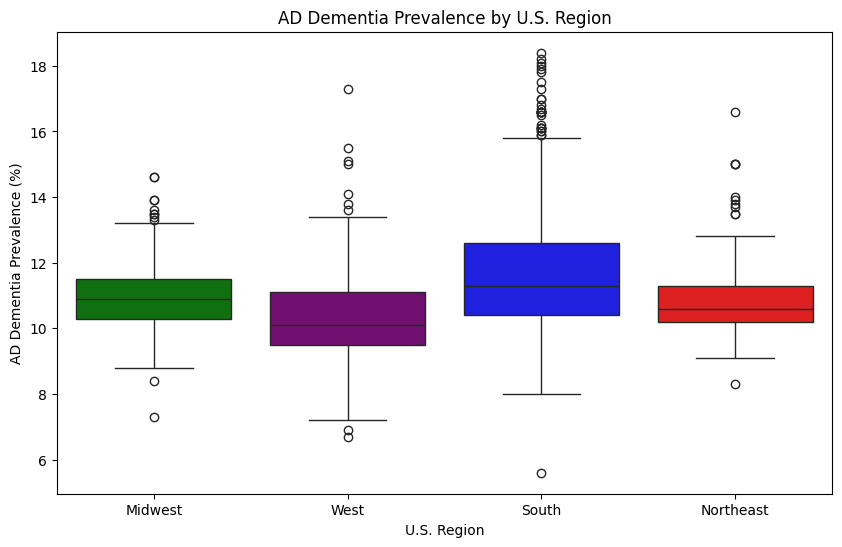

In [287]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = {
    'Northeast': 'red',
    'South': 'blue',
    'Midwest': 'green',
    'West': 'purple'
}

# Create the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='region', y='Prevalence', data=merged_data, palette=custom_palette)

# Add labels and title
ax.set_xlabel("U.S. Region")
ax.set_ylabel("AD Dementia Prevalence (%)")
plt.title("AD Dementia Prevalence by U.S. Region")

# Remove horizontal lines (gridlines)
ax.grid(False)
plt.savefig('ad_dementia_prevalence_by_region.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

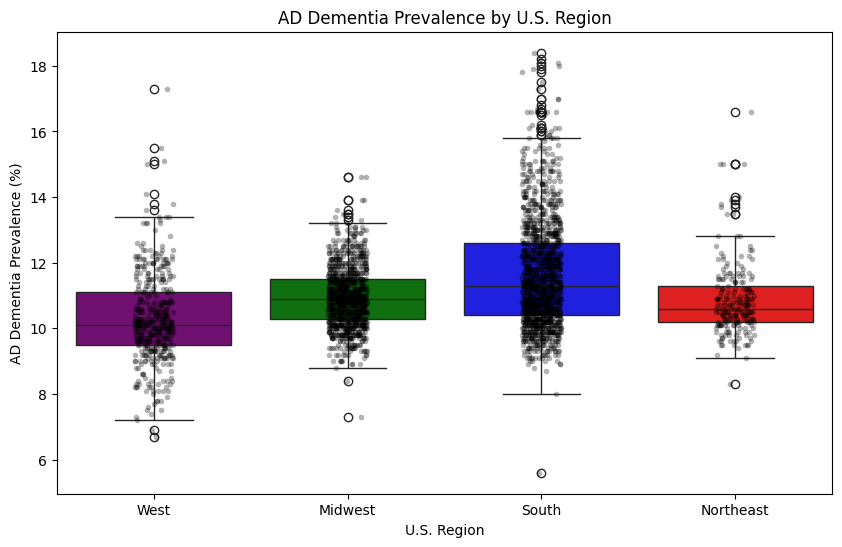

In [288]:
# Define custom color palette and new region order
custom_palette = {
    'West': 'purple',
    'Midwest': 'green',
    'South': 'blue',
    'Northeast': 'red'
}
region_order = ['West', 'Midwest', 'South', 'Northeast']

# Set up the plot
plt.figure(figsize=(10, 6))

# Create boxplot with reordered regions
sns.boxplot(x='region', y='Prevalence', data=merged_data, 
            order=region_order, palette=custom_palette)

# Add jittered individual data points (stripplot)
sns.stripplot(x='region', y='Prevalence', data=merged_data, 
              order=region_order, color='black', size=4, jitter=True, alpha=0.3)

# Customize plot
plt.xlabel("U.S. Region")
plt.ylabel("AD Dementia Prevalence (%)")
plt.title("AD Dementia Prevalence by U.S. Region")
plt.grid(False)

# Save and show the plot
plt.savefig('ad_dementia_prevalence_by_region.png', dpi=300, bbox_inches='tight')
plt.show()


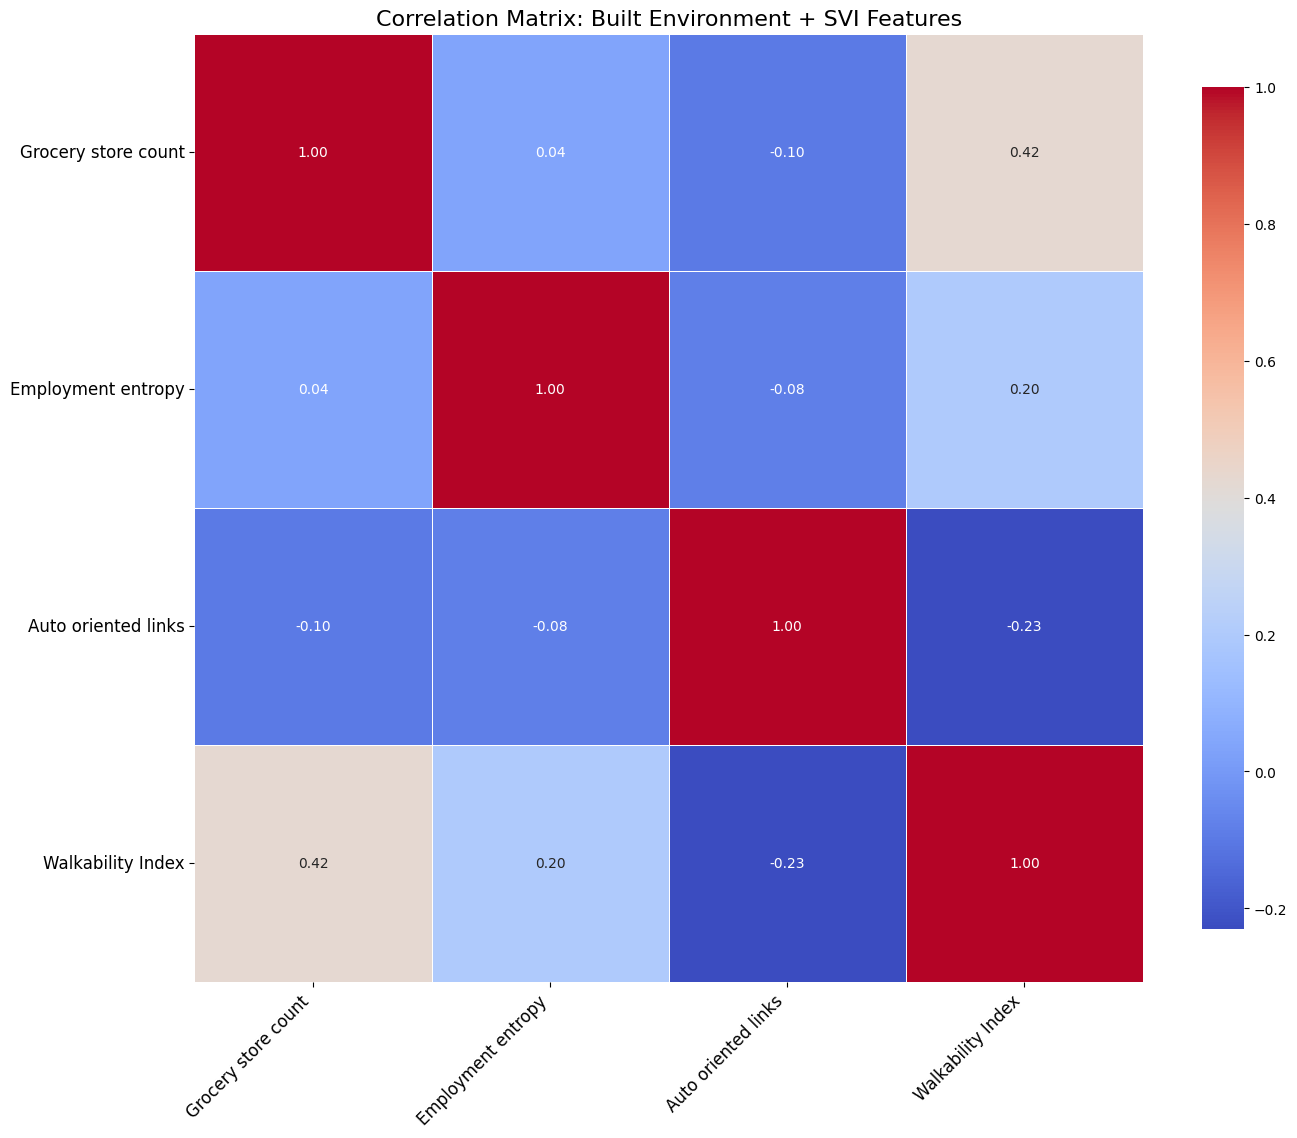

In [289]:
correlation_df = merged_data[built_environment_features]

# Compute the correlation matrix
corr_matrix = correlation_df.corr()

# Plot the correlation matrix with increased font size
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    annot_kws={"size": 10}  # increase annotation font size
)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.title("Correlation Matrix: Built Environment + SVI Features", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_be_svi.png", dpi=300)
plt.show()

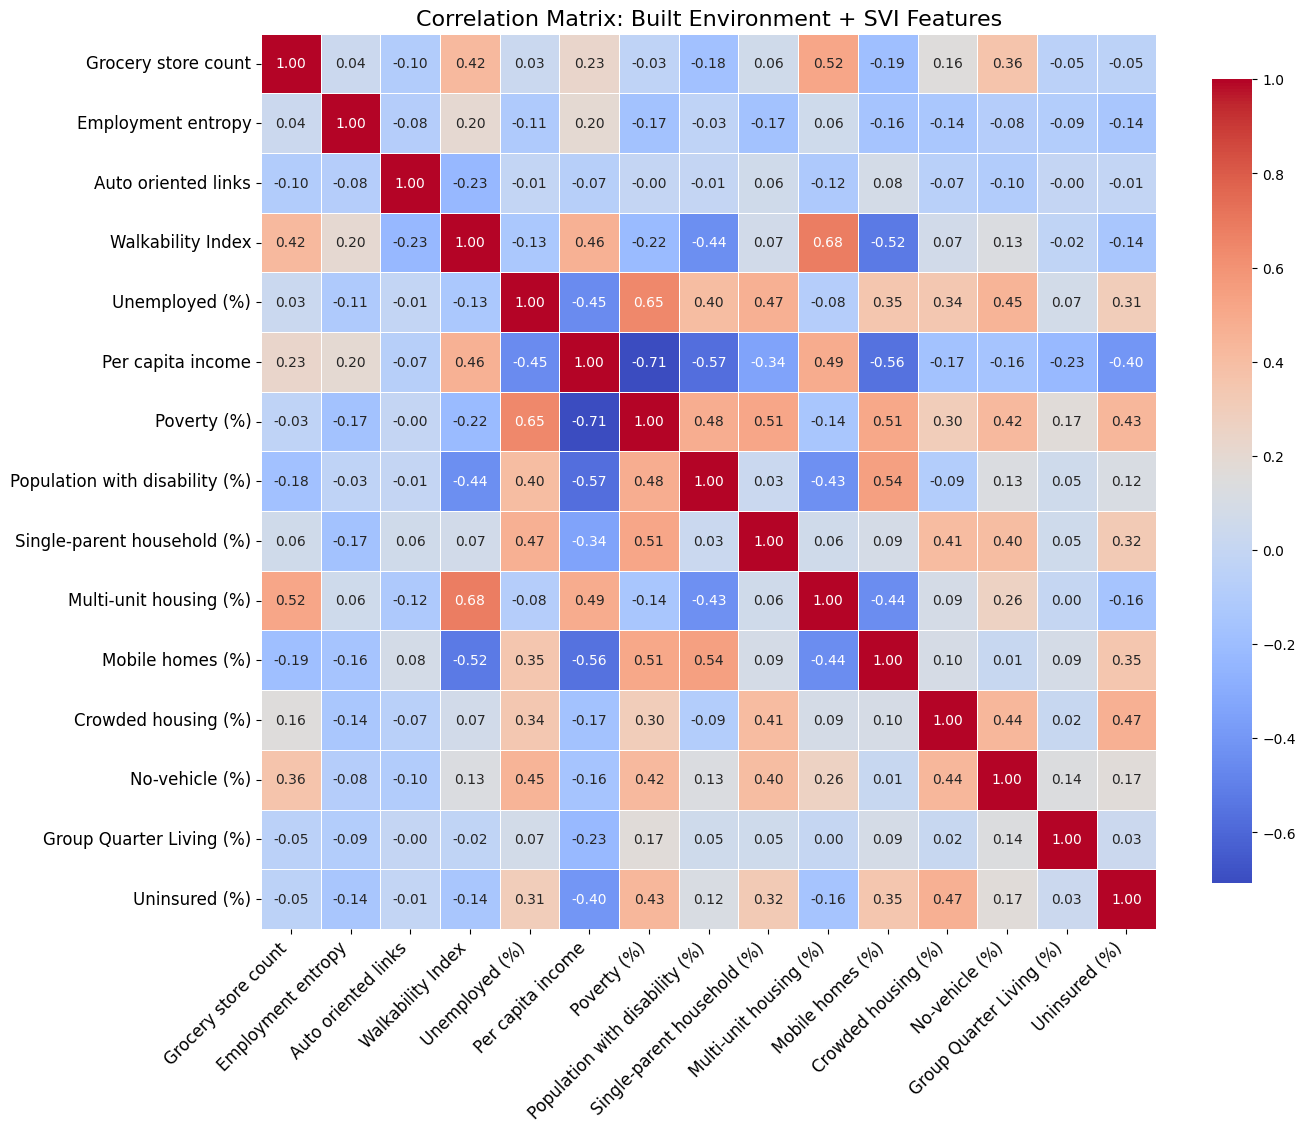

In [290]:
# Subset the dataframe to include only the built_env_svi features
correlation_df = merged_data[built_env_svi]

# Compute the correlation matrix
corr_matrix = correlation_df.corr()

# Plot the correlation matrix with increased font size
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    annot_kws={"size": 10}  # increase annotation font size
)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.title("Correlation Matrix: Built Environment + SVI Features", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_be_svi.png", dpi=300)
plt.show()

In [291]:
# Create a copy of the subset
data_subset = merged_data[built_env_svi].copy()

# Calculate summary statistics
summary_stats = data_subset.agg(['min', 'max', 'mean']).transpose()
summary_stats.columns = ['Min', 'Max', 'Average']

# View results
print(summary_stats)

                                     Min           Max       Average
Grocery store count             0.000000   2495.000000     20.766093
Employment entropy              0.000000      0.959350      0.727001
Auto oriented links             0.000000      1.983756      0.250904
Walkability Index               2.166667     16.000000      6.222780
Unemployed (%)                  0.000000     28.900000      5.770841
Per capita income               0.000000  72832.000000  27019.775972
Poverty (%)                     0.000000     55.100000     15.592352
Population with disability (%)  3.800000     33.700000     15.925175
Single-parent household (%)     0.000000     25.700000      8.320172
Multi-unit housing (%)          0.000000     89.400000      4.663289
Mobile homes (%)                0.000000     59.300000     12.931517
Crowded housing (%)             0.000000     49.300000      2.422690
No-vehicle (%)                  0.000000     87.800000      6.342670
Group Quarter Living (%)        0.

In [292]:
# List of region names for labeling
region_names = ['Northeast', 'Midwest', 'South', 'West']

# Loop through each regional DataFrame and calculate summary stats
for df, name in zip(regions, region_names):
    data_subset = df[built_env_svi].copy()
    summary_stats = data_subset.agg(['min', 'max', 'mean']).transpose()
    summary_stats.columns = ['Min', 'Max', 'Average']
    
    print(f"\nSummary Statistics for {name} Region:")
    print(summary_stats)



Summary Statistics for Northeast Region:
                                         Min           Max       Average
Grocery store count                 1.000000   2495.000000     87.115207
Employment entropy                  0.637863      0.871739      0.756159
Auto oriented links                 0.000000      0.753417      0.102012
Walkability Index                   4.166667     15.000000      7.961214
Unemployed (%)                      2.200000     10.500000      5.458986
Per capita income               15360.000000  72832.000000  32605.589862
Poverty (%)                         4.600000     29.100000     12.188940
Population with disability (%)      8.000000     28.500000     14.316590
Single-parent household (%)         1.600000     19.100000      7.972350
Multi-unit housing (%)              0.300000     89.400000      7.558525
Mobile homes (%)                    0.000000     20.800000      6.364055
Crowded housing (%)                 0.300000     12.300000      1.747005
No-vehicl